# Wealth vs Quality of Life - Do richer places lead better lives?
> *Sam Leahy, Juliana Lima, Bethania Sequera, Alex Tsai, Yi Zhang*

They say where you're born determines your future. Even with just a quick search online seems to suggest that many believe the ZIP Code you're born in greatly determines your station in life, including the [New York Times](https://www.nytimes.com/2020/05/19/learning/how-much-has-your-zip-code-determined-your-opportunities.html), [National Community Reinvestment Coalition](https://www.ncrc.org/your-zip-code-is-more-important-than-your-genetic-code/), and [Time Magazine](https://time.com/5608268/zip-code-health/).

However, how much of that statement is true? How much of those assumptions are verifiable? Is your birthplace really as much of an indicator of success as the pundits suggest? Does it really take a village to raise a child or does luck and individual aptitude play more of a factor? We hope to answer at least some aspects of this topic through 4 main questions.

## Contents:
### Setup:
1. [Modules and Dependencies](#M&D)
2. [API Requirements](#API)
### Question 1: Do richer places have better health outcomes?
> *Kinda. Some health outcomes don't seem to be dependent on the relative wealth of an area, though which ones those are may surprise you*
1. [Metric Definitions](#MD1)
2. [Data Cleaning](#DC1)
3. Exploratory Data Analysis - Each subsection has a graphic and a brief analysis of the data reviewed
    - [Wealth Check](#EDA1-1)
    - [A Geographical View of Wealth](#EDA1-2)
    - [Health Check](#EDA1-3)
    - [Outlier Control](#EDA1-4)
4. Insights
    - [Correlation Table](#INS1-1) and more
    - [Linear Regressions](#INS1-2)
    - [Geographical Visualizations](#INS1-3)

### Question 2: Do richer places have better housing conditions?
> *Not really*
1. [Data Cleaning](#DC2)
2. [Exploratory Data Analysis](#EDA2)
3. [Insights](#INS2)

### Question 3: Do richer places have better energy utilities?

### Question 4: Do richer places have better public order?
1. [Data Cleaning](#DC4)
2. [Insights](#INS4)

<a id='M&D'></a>
# Setup
## Modules and Dependencies
Generally, all of the modules used here either come built-in with Python or the environment installed with the Conda command:
```python
conda create -n dev python=3.10 anaconda -y
```
If necessary, please follow the instructions on the associated [Github README file](https://github.com/AlexPei-YuTsai/BerkeleyDataBootcampProjectONE#installationprerequisites) and acquire all the packages necessary with the package installer of your choice as per each module's respective installation instructions.

In [46]:
# Using these for processing CSV files and doing math
from pathlib import Path
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import math

# Using these to plot out geographical data
import hvplot.pandas
from holoviews.operation.datashader import rasterize

# Using these for any APIs we call
import requests
import json

<a id= "API"></a>
## API Requirements
Some of the data used for our research was extracted online through HTTP requests and API calls. As API keys are not uploaded onto our GitHub repository for security reasons, please follow our [GitHub README documentation regarding that topic](https://github.com/AlexPei-YuTsai/BerkeleyDataBootcampProjectONE#api-keys) and install any API keys needed for your own data extraction and replication purposes. 

In [2]:
# Question 1: Do richer places have better health outcomes?

# NO API KEYS REQUIRED - Any data used is extracted from the "PLACES" CSV file downloaded from the CDC's website
# NOTE: Optionally, you can import the module below if you'd rather use the CDC's API to access data
# NOTE: However, you can't get an API Token without working for them, so I do not recommend doing things this way given their throttling limits

# Question 2: Do richer places have better housing conditions?

# Question 3: Do richer places have better energy utilities?

# Question 4: Do richer places have better public order?

# NO API KEYS REQUIRED - Any data used is extracted online and placed in the Resources folder for your perusal

<a id='MD1'></a>
# Question 1: Do richer places have better health outcomes?
Logical reasoning dictates that if you need money to afford healthcare, then the richer households should have better healthcare and consequently lead healthier lives. However, is that true and to what extent is that assumption true? 

To answer this question, data from the IRS is used as a means of measuring "wealth" while data from the CDC is used as a means of measuring "health". The scope of our "places" is defined such that we are comparing wealth and health data on a **ZIP Code-level**.

## Metric Definitions
After some data cleaning and preparation, all of the charts and graphical representations of the data is generated with the `AGI+medical_data.csv` file exported into the `Resources` folder of this repository. These are the definitions of the columns in that exported dataframe:

### For Identification (This is also the basic point of data in which our metrics will be compared upon):
- **ZIPCODE:** The official 5-digit postal code of a particular area as defined by the data given by 2020 United States Postal Service. 
    - e.g.: 33480 is the ZIP Code for Palm Beach
- STATE: The 2-letter state abbreviation for the state a ZIP Code belongs to. 
    - e.g.: "NY" is New York, "CA" is California.
- lng: The longitude of a given ZIP Code in positive and negative degrees. Everything positive is *east* of the Prime Meridian, everything negative is *west* of it.
- lat: The latitude of a given ZIP Code. Everything positive is *north* of the equator, everything negative is *south* of it.

### For Wealth:

All of the data here is derived from the IRS's [2020 SOI Tax Data](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2020-zip-code-data-soi). The exact documentation can be downloaded from that website for your personal perusal.

- Total Individuals: The `N2` column of the raw downloadable tax data. Represents the number of individuals in that ZIP Code.  
- Total Income Amount: The `A02650` column. Represents the total income amount reported for a given ZIP Code in *thousands of dollars*.
- **Total Income per Individual(This is our definition of the "Wealth" of a ZIP Code):** Divide the Total Income Amount by the Total Individuals to get the Total Income per Individual of a ZIP Code. Since different ZIP Codes have different populations, we chose to normalize the wealth of each region by examining the average total income of each individual residing in that tabulated region.
    - *Disclaimer: The data might not be fully representative of the US's populations as many people are exempt from filing tax returns. However, as this is official IRS data, we find their data to be a suitable estimate even if the actual numbers are off.*
    
### For Health:

Each of our 30 other data column is collected from the [CDC's PLACES data](https://chronicdata.cdc.gov/500-Cities-Places/PLACES-ZCTA-Data-GIS-Friendly-Format-2022-release/kee5-23sr) and is a measure of some kind of health phenomenon. The exact data dictionary can be found in the previous link and their definition for what "prevalence" is and how it's calculated can be found in their [PLACES measure definitions](https://www.cdc.gov/places/measure-definitions/) page.

To summarize, the CDC's dataset has 4 kinds of health metrics: Health Outcomes (Arthritis, Cancer, etc.), Prevention (Various screenings and health insurance coverage), Health Risk Behaviors (Binge drinking, smoking, things that usually lead to poor health), and Health Status (Different ways people rate their own health).

Each metric is a "crude prevalence" reflecting a weighted, modified (depending on the methodology), estimated fraction of the resident adults of each ZIP Code with that given phenomenon where the denominator is the total considered population and the numerator is usually those who have been diagnosed with that condition by a licensed medical professional. Each of the data definitions below is merely a simple description, so do visit the sources given for a more comprehensive understanding of the scope and limits of each metric.

**Every column here is Health data compared with our Wealth metric (Names in `these marks` are the original names from the raw CDC PLACES CSV data):**

*Health Outcomes*

- Arthritis: `ARTHRITIS_CrudePrev` column. Prevalence of arthritis among adults over 18 years old.
- Current Asthma: `CASTHMA_CrudePrev` column. Prevalence of currently asthmatic adults over 18 years old.
- High Blood Pressure: `BPHIGH_CrudePrev` column. Prevalence of high blood pressure among adults over 18 years old.
- (Non-Skin) Cancer: `CANCER_CrudePrev` column. Prevalence of cancer (excluding skin cancer) among adults over 18 years old.
- High Cholesterol: `HIGHCHOL_CrudePrev` column. Prevalence of high cholesterol among adults over 18 years old.
- Chronic Kidney Disease: `KIDNEY_CrudePrev` column. Prevalence of chronic kidney disease among adults over 18 years old.
- Chronic Obstructive Pulmonary Disease: `COPD_CrudePrev` column. Prevalence of chronic obstructive pulmonary disease among adults over 18 years old.
- Coronary Heart Disease: `CHD_CrudePrev` column. Prevalence of coronary heart disease among adults over 18 years old.
- Depression: `DEPRESSION_CrudePrev` column. Prevalence of depression among adults over 18 years old.
- Diabetes: `DIABETES_CrudePrev` column. Prevalence of diagnosed diabetes among adults over 18 years old (excluding diabetes during pregnancy).
- Obesity: `OBESITY_CrudePrev` column. Prevalence of obesity among adults over 18 years old based on BMI results (excluding certain people and pregnant women).
- All Teeth Lost (Older Adults): `TEETHLOST_CrudePrev` column. Prevalence of losing all natural teeth due to tooth decay or gum disease among adults over 65 years old.
- Stroke: `STROKE_CrudePrev` column. Prevalence of strokes among adults over 18 years old.
- Cervical Cancer (Adult Women): `CERVICAL_CrudePrev` column. Prevalence of cervical cancer amongst adult women between 21 to 65 years old.

*Prevention*

- Lacking Health Insurance: `ACCESS2_CrudePrev` column. Prevalence of respondents who report having no current health insurance coverage amongst adults between 18 to 64 years old.
- Routine Health Checkups: `CHECKUP_CrudePrev` column. Prevalence of respondents who report having been to a doctor for a routine checkup (e.g., a general physical exam, not an exam for a specific injury, illness, condition) in the previous year amongst adults over 18 years old.
- Dentist Visits: `DENTAL_CrudePrev` column. Prevalence of respondents who report having been to the dentist or dental clinic in the previous year amongst adults over 18 years old.
- Taking Medicine for High Blood Pressure: `BPMED_CrudePrev` column. Prevalence of respondents who report taking medicine for high blood pressure amongst adults over 18 years old who have been diagnosed with high blood pressure.
- Cholesterol Screening: `CHOLSCREEN_CrudePrev` column. Prevalence of respondents who report having their cholesterol checked within the previous 5 years amongst adults over 18 years old.
- Mammography (Older Women): `MAMMOUSE_CrudePrev` column. Prevalence of respondents who report having had a mammogram within the previous 2 years amongst adult women between 50 to 74 years old.
- FOBT/Colon Screening (Older Adults): `COLON_SCREEN_CrudePrev` column. Prevalence of respondents who report having had 1) a fecal occult blood test (FOBT) within the past year, 2) a sigmoidoscopy within the past 5 years and a FOBT within the past 3 years, or 3) a colonoscopy within the past 10 years amongst adults between 50 to 75 years old.
- Core Clinical Prevention (Older Women): `COREW_CrudePrev` column. Prevalence of respondents reporting having received all of the following: an influenza vaccination in the past year; a pneumococcal vaccination (PPV) ever; either a fecal occult blood test (FOBT) within the past year, a sigmoidoscopy within the past 5 years and a FOBT within the past 3 years, or a colonoscopy within the previous 10 years; and a mammogram in the past 2 years amongst adult women over 65 years old.
- Core Clinical Prevention (Older Men): `COREM_CrudePrev` column. Prevalence of respondents reporting having received all of the following: an influenza vaccination in the past year; a PPV ever; and either a fecal occult blood test (FOBT) within the past year, a sigmoidoscopy within the past 5 years and a FOBT within the past 3 years, or a colonoscopy within the past 10 years amongst adult men over 65 years old.

*Health Risk Behaviors*

- Binge Drinking: `BINGE_CrudePrev` column. Prevalence of adults over 18 years old who report having five or more drinks (men) or four or more drinks (women) on an occasion in the past 30 days.
- Currently Smoking: `CSMOKING_CrudePrev` column. Prevalence of respondents who report having smoked ≥100 cigarettes in their lifetime and currently smoke every day or some days amongst adults over 18 years old.
- No Leisure-Time Physical Activity: `LPA_CrudePrev` column. Prevalence of respondents who answered “no” to the following question: “During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?” amongst adults over 18 years old.
- Less than 7 Hours of Sleep: `SLEEP_CrudePrev` column. Prevalence of respondents who report usually getting insufficient sleep (<7 hours for those aged ≥18 years, on average, during a 24-hour period) amongst adults over 18 years old.

*Health Status*

- 'Poor' Self-Rated Mental Health Status: `MHLTH_CrudePrev` column. Prevalence of respondents who report 14 or more days during the past 30 days during which their mental health was not good amongst adults over 18 years old.
- 'Poor' Self-Rated Physical Health Status: `PHLTH_CrudePrev` column. Prevalence of respondents who report 14 or more days during the past 30 days during which their physical health was not good among adults over 18 years old.
- 'Fair' or 'Poor' Self-Rated Health Status: `GHLTH_CrudePrev` column. Prevalence of respondents who report their general health status as “fair” or “poor.”

Any potential limitations in their dataset can be found on their website in the PLACES measure definitions page given above.

<a id='DC1'></a>
## Data Cleaning

The file below named `AGI+coords_data.csv` is processed from a larger file that is not included in this GitHub repository due to its sheer size. However, for those who are interested, the file used merges select columns of the [Statistics of Income  - Tax Data from the IRS](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2020-zip-code-data-soi) file with the [ZIP Codes to Map Coordinates conversion file](https://simplemaps.com/data/us-zips).

As per the Metric Definitions above, we only selected the columns the `STATE`, `ZIPCODE`, `N2`, and `A02650` columns, which later got merged with the `Resources/uszips.csv` file's `zip`, `lat`, and `lng` columns. The data was merged on the ZIP Code columns both CSV files have. Furthermore, the data may have been sorted by Total Income per Individual beforehand.

In [3]:
# Get Independent Variable Data
test_df = pd.read_csv("Resources/AGI+coords_data.csv")

# As per the Metric Definitions, all money columns here are in thousands of dollars

# Also dropped 3 rows because some ZIPs didn't have coordinates, apparently. Columns renamed for personal convenience
test_df = test_df.drop(["Unnamed: 0", "index"], axis=1).dropna(axis="index", how="any").rename(columns={"N2":"Total Individuals", "A02650":"Total Income Amount"})
test_df

STATE  ZIPCODE  Total Individuals  Total Income Amount  \
0        MS    38738              140.0         5.770000e+02   
1        MO    64147              280.0         1.591000e+03   
2        SD    57794              390.0         3.206000e+03   
3        TN    37140              390.0         3.239000e+03   
4        MT    59444              270.0         2.321000e+03   
...     ...      ...                ...                  ...   
27637    CA    94301            14750.0         1.527798e+07   
27638    CA    94027             5820.0         6.971688e+06   
27639    FL    33480             9050.0         1.466156e+07   
27640    CA    94104             1510.0         2.990505e+06   
27641    FL    33109              520.0         1.578682e+06   

       Total Income per Individual        lng       lat  
0                         4.121429  -90.53653  33.93049  
1                         5.682143  -94.54688  38.85387  
2                         8.220513 -102.40695  43.12071  
3                         8.305128  -87.65245  35.86345  
4                         8.596297 -111.34881  48.65227  
...                            ...        ...       ...  
27637                  1035.795390 -122.14992  37.44424  
27638                  1197.884536 -122.20313  37.45399  
27639                  1620.061768  -80.04075  26.69796  
27640                  1980.466887 -122.40211  37.79144  
27641                  3035.926924  -80.14197  25.76160  

[27639 rows x 7 columns]

Next, we have to import the dependent variables. All this is extracted from the CDC's PLACES data referred to in the Metric Definitions section and the full CSV can be found in the `Resources` folder if better analysis can be made with the columns I chose not to use.

The goal is to correlate the Total Income per Individual with the various health metrics described to see if ZIP Codes with higher average individual wealth have better health than those with lower average individual wealth.

Though ZCTA5 isn't completely equivalent to ZIPCodes according to online definitions, it's close enough such that it's generally interexchangeable given how they are mostly, if not completely equal in terms of their general coordinate positions. Also, all the `95CI` columns, data describing the upper and lower bound of their estimates given their 95% confidence interval, are dropped as we only need to find correlations with one type of metric (bigger numbers or smaller numbers for all would not change the strength of a correlation). Lastly, the `TotalPopulation` and `Geolocation` columns are dropped as they are not necessary with the corresponding data columns we have in our `AGI+coords_data.csv` file.

In [4]:
# Get Dependent Variable Data
med_df = pd.read_csv("Resources/PLACES__ZCTA_Data__GIS_Friendly_Format___2022_release.csv")
med_df

# TotalPopulation and Geolocation columns match up pretty well with the tax information dataset, so these columns are also safe to ignore

ZCTA5  TotalPopulation  ACCESS2_CrudePrev ACCESS2_Crude95CI  \
0       8065             7398               11.8      (10.6, 13.0)   
1      28443            17512               13.7      (12.4, 15.1)   
2       3103            36476               16.1      (15.2, 17.1)   
3       4042             4281               12.0      ( 9.6, 14.7)   
4       1109            30250               14.1      (13.2, 15.1)   
...      ...              ...                ...               ...   
32404  90249            26669               15.7      (14.7, 16.8)   
32405  92551            30815               21.0      (19.7, 22.3)   
32406  98226            41235               10.3      ( 9.7, 11.0)   
32407  87553             1209               19.8      (16.5, 23.5)   
32408  95620            20553               15.1      (13.7, 16.5)   

       ARTHRITIS_CrudePrev ARTHRITIS_Crude95CI  BINGE_CrudePrev  \
0                     23.6        (22.8, 24.3)             17.0   
1                     25.2        (24.5, 25.9)             16.3   
2                     23.4        (22.9, 23.8)             18.0   
3                     25.6        (24.2, 26.9)             16.6   
4                     24.6        (24.3, 24.9)             14.8   
...                    ...                 ...              ...   
32404                 17.9        (17.5, 18.3)             15.6   
32405                 17.1        (16.9, 17.4)             19.0   
32406                 24.8        (24.3, 25.3)             19.0   
32407                 25.2        (24.2, 26.3)             11.9   
32408                 19.4        (19.0, 19.9)             19.4   

      BINGE_Crude95CI  BPHIGH_CrudePrev BPHIGH_Crude95CI  ...  \
0        (16.8, 17.2)               NaN              NaN  ...   
1        (16.1, 16.5)              33.1     (32.3, 33.8)  ...   
2        (17.8, 18.2)              29.4     (29.0, 29.8)  ...   
3        (16.0, 17.2)              29.7     (28.3, 31.1)  ...   
4        (14.5, 14.9)              33.9     (33.6, 34.2)  ...   
...               ...               ...              ...  ...   
32404    (15.5, 15.7)              29.8     (29.4, 30.2)  ...   
32405    (18.8, 19.2)              27.4     (27.1, 27.7)  ...   
32406    (18.8, 19.2)              29.8     (29.3, 30.2)  ...   
32407    (11.5, 12.1)              35.0     (33.8, 36.2)  ...   
32408    (18.9, 19.8)              25.1     (24.6, 25.6)  ...   

       OBESITY_Crude95CI PHLTH_CrudePrev  PHLTH_Crude95CI SLEEP_CrudePrev  \
0           (31.5, 33.0)             9.2     ( 8.7,  9.7)            36.9   
1           (27.3, 28.8)             9.2     ( 8.7,  9.7)            32.0   
2           (32.4, 33.4)            11.3     (10.8, 11.7)            36.2   
3           (29.3, 32.5)             8.5     ( 7.5,  9.5)            33.1   
4           (37.7, 38.6)            12.4     (12.0, 12.8)            42.2   
...                  ...             ...              ...             ...   
32404       (29.4, 30.4)             9.8     ( 9.4, 10.2)            35.6   
32405       (36.6, 37.4)            11.0     (10.6, 11.4)            37.6   
32406       (27.4, 28.2)            10.4     (10.1, 10.7)            28.4   
32407       (27.8, 29.6)            13.9     (13.2, 14.7)            32.4   
32408       (31.2, 32.5)            10.4     ( 9.9, 10.8)            33.9   

       SLEEP_Crude95CI STROKE_CrudePrev  STROKE_Crude95CI TEETHLOST_CrudePrev  \
0         (36.0, 37.7)              2.8      ( 2.7,  3.0)                12.4   
1         (31.2, 32.8)              2.8      ( 2.7,  3.0)                10.3   
2         (35.7, 36.7)              2.8      ( 2.6,  2.9)                17.0   
3         (31.4, 34.7)              2.4      ( 2.2,  2.7)                13.0   
4         (41.6, 42.7)              4.0      ( 3.8,  4.1)                25.6   
...                ...              ...               ...                 ...   
32404     (35.0, 36.1)              3.0      ( 2.9,  3.2)                11.2   
32405  

In [5]:
# We'll ignore any of the CI columns and keep the ZCTA5 column, so there should be 31 columns left

# Extract all Prevalence columns
prev_df = med_df.filter(like="Prev")

# Can't forget to get the ZIP Code data or else there would be nothing to merge on
prev_df.insert(0, "ZIPCODE", med_df.loc[:, "ZCTA5"])

# Drop nulls
a_df = prev_df.dropna(axis="index", how="any")

# Join data on ZIP Codes, drop nulls again just in case, and rename them for presentation purposes
medical_df = test_df.merge(a_df, how="left", on="ZIPCODE").dropna(axis="index", how="any")\
.rename(columns=
        {# Health Outcomes
         "ARTHRITIS_CrudePrev":"Arthritis", "BPHIGH_CrudePrev":"High Blood Pressure", "CANCER_CrudePrev":"(Non-Skin) Cancer", 
         "CASTHMA_CrudePrev":"Current Asthma", "CERVICAL_CrudePrev":"Cervical Cancer (Adult Women)", "CHD_CrudePrev":"Coronary Heart Disease",
         "COPD_CrudePrev":"Chronic Obstructive Pulmonary Disease", "DEPRESSION_CrudePrev":"Depression", "DIABETES_CrudePrev":"Diabetes",
         "HIGHCHOL_CrudePrev":"High Cholesterol", "KIDNEY_CrudePrev":"Chronic Kidney Disease", "OBESITY_CrudePrev":"Obesity", "STROKE_CrudePrev":"Stroke", "TEETHLOST_CrudePrev":"All Teeth Lost (Older Adults)",
         # Prevention 
         "ACCESS2_CrudePrev":"Lacking Health Insurance", "BPMED_CrudePrev":"Taking Medicine for High Blood Pressure",
         "CHECKUP_CrudePrev":"Routine Health Checkups", "CHOLSCREEN_CrudePrev":"Cholesterol Screening", 
         "COLON_SCREEN_CrudePrev":"FOBT/Colon Screening (Older Adults)",  "COREM_CrudePrev":"Core Clinical Prevention (Older Men)", "COREW_CrudePrev":"Core Clinical Prevention (Older Women)",
         "DENTAL_CrudePrev":"Dentist Visits", "MAMMOUSE_CrudePrev":"Mammography (Older Women)",
         # Health Risk Behaviors
         "BINGE_CrudePrev":"Binge Drinking", "CSMOKING_CrudePrev":"Currently Smoking", "LPA_CrudePrev":"No Leisure-Time Physical Activity",
         "SLEEP_CrudePrev":"Less than 7 Hours of Sleep", 
         # Health Status
         "GHLTH_CrudePrev":"'Fair' or 'Poor' Self-Rated Health Status", "MHLTH_CrudePrev":"'Poor' Self-Rated Mental Health Status", 
         "PHLTH_CrudePrev":"'Poor' Self-Rated Physical Health Status"
        })

# Note: Each of the Health Outcomes columns is the "Crude Prevalence" of that particular health phenomenon
# Note: Unless mentioned otherwise, these stats are measured for adults
medical_df

STATE  ZIPCODE  Total Individuals  Total Income Amount  \
0        MS    38738              140.0         5.770000e+02   
1        MO    64147              280.0         1.591000e+03   
2        SD    57794              390.0         3.206000e+03   
3        TN    37140              390.0         3.239000e+03   
4        MT    59444              270.0         2.321000e+03   
...     ...      ...                ...                  ...   
27634    CA    94301            14750.0         1.527798e+07   
27635    CA    94027             5820.0         6.971688e+06   
27636    FL    33480             9050.0         1.466156e+07   
27637    CA    94104             1510.0         2.990505e+06   
27638    FL    33109              520.0         1.578682e+06   

       Total Income per Individual        lng       lat  \
0                         4.121429  -90.53653  33.93049   
1                         5.682143  -94.54688  38.85387   
2                         8.220513 -102.40695  43.12071   
3                         8.305128  -87.65245  35.86345   
4                         8.596297 -111.34881  48.65227   
...                            ...        ...       ...   
27634                  1035.795390 -122.14992  37.44424   
27635                  1197.884536 -122.20313  37.45399   
27636                  1620.061768  -80.04075  26.69796   
27637                  1980.466887 -122.40211  37.79144   
27638                  3035.926924  -80.14197  25.76160   

       Lacking Health Insurance  Arthritis  Binge Drinking  ...  \
0                          32.1       18.5            17.6  ...   
1                          19.1        9.0            21.1  ...   
2                          20.0       24.0            19.7  ...   
3                          27.6       17.0            19.5  ...   
4                          15.2       26.5            22.4  ...   
...                         ...        ...             ...  ...   
27634                       4.9       19.2            18.2  ...   
27635                       4.9       22.6            15.6  ...   
27636                      10.7       32.9             8.6  ...   
27637                      10.7       20.3            13.5  ...   
27638                      16.7       30.8            11.0  ...   

       High Cholesterol  Chronic Kidney Disease  \
0                  28.1                     2.6   
1                  13.2                     1.2   
2                  24.3                     4.4   
3                  25.8                     2.0   
4                  31.6                     3.0   
...                 ...                     ...   
27634              29.0                     2.4   
27635              36.9                     2.7   
27636              42.1                     4.4   
27637              34.1                     2.9   
27638              39.6                     4.1   

       No Leisure-Time Physical Activity  Mammography (Older Women)  \
0                                   33.0                       79.5   
1                                   22.9                       81.3   
2                                   38.5                       73.4   
3                                   28.5                       70.0   
4                                   23.5                       70.1   
...                                  ...                        ...   
27634                               12.7                       76.6   
27635                               12.7                       76.1   
27636                               20.2                       79.3   
27637                               22.5                       65.4   
27638                               26.2                       76.0   

       'Poor' Self-Rated Mental Health Status  Obesity  \
0                                        15.5     49.2   
1                                        21.9     31.9   
2                                        20.0     45.5   
3                        

<a id="EDA1-1"></a>
## Exploratory Data Analysis

The following is some of the univariate and bivariate data explorations we did to get a better understanding of what we are looking at.

### Wealth Check

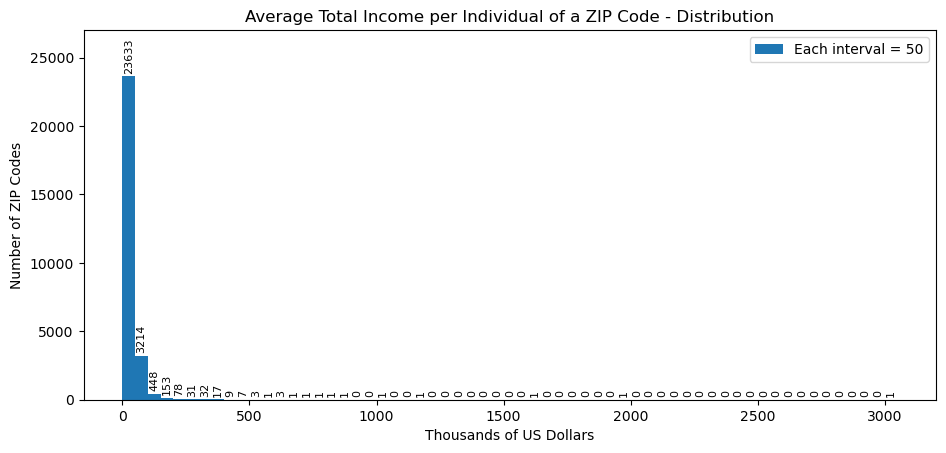

Minimum: 4.121428571428571
Maximum: 3035.926923653846
Mean: 39.052928410344045
Median: 31.46428577380952
1st Quartile: 25.873887987012985
3rd Quartile: 40.45460299965004
IQR: 14.580715012637057
Safe Bounds: 4.002815468057399 - 62.32567551860563


In [6]:
# Setting up a histogram here

# This bit of code is for me to manually set up bin intervals for easier readability
dbins = [i*50.0 for i in range(62)]

plt.figure(figsize=(11,4.8)) 
counts, bins, bars = plt.hist(test_df["Total Income per Individual"], bins=dbins, label="Each interval = 50")
plt.bar_label(bars, fontsize=8, rotation="vertical", padding=2)
plt.ylim(0,27000)
plt.title("Average Total Income per Individual of a ZIP Code - Distribution")
plt.xlabel("Thousands of US Dollars")
plt.ylabel("Number of ZIP Codes")
plt.legend()

plt.show()

# If you're wondering why the chart is so wide, it's because wealth disparity sucks and the Income/Capita in Miami Beach is $3 million
# This calls for a little outlier treatment
q1 = np.quantile(test_df["Total Income per Individual"], .25)
q3 = np.quantile(test_df["Total Income per Individual"], .75)
iqr = q3-q1
ub = 1.5*iqr+q3
lb = q1-1.5*iqr
print(f"Minimum: {test_df['Total Income per Individual'].min()}")
print(f"Maximum: {test_df['Total Income per Individual'].max()}")
print(f"Mean: {test_df['Total Income per Individual'].mean()}")
print(f"Median: {test_df['Total Income per Individual'].median()}")
print(f"1st Quartile: {q1}")
print(f"3rd Quartile: {q3}")
print(f"IQR: {iqr}")
print(f"Safe Bounds: {lb} - {ub}")

# We'll be using the "1.5xIQR rule" heuristic and saving the upper bound for further data treatment later if necessary
# The lower bound is not necessary because none of the data will ever exceed that

You can notice that 85% of all ZIP Codes here in the US has an average Total Income per Individual of less than or equal to $50,000. Considering that the maximum of this dataset is easily over 60 times the value of that bar and 50 times over the upper bound of the 1.5xIQR rule, it's easy to see how the outliers of this dataset easily affected the mean and any other statistic regarding averages.

The median ZIP Code has people earning about $30,000 per tax year, which is rather unfortunate. Perhaps it's poor calculation on our part, but it definitely seemed a lot lower than expected.

<a id="EDA1-2"></a>
### A Geographical View of Wealth
There's this neat little data visualization method called ["choropleth maps"](https://en.wikipedia.org/wiki/Choropleth_map) that is very fascinating and compelling when geographical data is involved. Using some Geographic Information System (GIS) magic and coding finesse, the product can easily tell people what the land is like at a glance by scaling the values of a particular data column with color and mapping them onto the geographical map of the land - a true application of the old adage "A picture is worth a thousand words."

Unfortunately, given our limited time, it didn't feel appropriate to waste too much time learning new modules and painstakingly debugging unfamiliar code, so we opted for an "off-brand" version with something we are more familiar with: HVPlot.

It's not a perfect visualization with demarcated ZIP Code tabulation areas, but the collection of points are still substantial enough to tell a story without us typing a single word.

We simply followed [HVPlot documentation](https://hvplot.holoviz.org/user_guide/Customization.html) to figure out what keyword arguments to include in these blocks of code to create a nation-level and state-level view of the US's wealth distribution.

*Note: Given their interactive functionality, HVPlot maps aren't saved on Jupyter Notebooks, so you'll have to run the notebook yourself to get an idea of what the maps look like. A static screenshot of the nation and state-level views are saved in `Results/EDA_Nation.png` and `Results/EDA_NY.png`, respectively. Please examine the folder and view them for yourself.*

In [7]:
# National View

# Map starts out pretty far because we're also including Hawaii and Alaska
# Non-datashaded map works, but it's super laggy with 27k points, so we'll stick with this for big visualizations

money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    datashade=True,
    dynspread=True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)
print("Black = Big Money, Yellow = Small Money")
money_plot

Black = Big Money, Yellow = Small Money


:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [lng,lat]   (R,G,B,A)

Due to some code issues we've decided not to pursue, the color legend does not appear with this datashaded version of the map. Because of the parameters we've included in the code block above, some patches of colors may also not be completely representative of the reality of the country.

*You can remove the `datashade = True` and `dynspread = True` keyword arguments to have a more accurate view of the US and have a color bar to indicate the relative wealth of a ZIP Code, but we advise against that unless your computer has substantial processing power given how computationally costly it is to graphically render 27,000 points on a map.*

However, even with this simple visualization, it's easy to see where the money is in this country. On the west coast, you can see big blobs of wealthy ZIP Codes around Los Angeles, San Francisco, and Seattle while the Northeast as a whole seems to be comparatively more comfortable than the rest of the country.

In [8]:
# State View
teststate_df = test_df.loc[test_df["STATE"]=="NY"]

money_plot = teststate_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)

money_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual)

Almost as if you're pinching a wet piece of tissue paper and pulling it up from the table, the wealth of New York seems to decrease drastically away from one single key point. You can notice how all the ZIP Codes with the highest average Total Income per Individual values are around or in Manhattan and that the colors of the dots rapidly go down to bright yellow as you leave the hustle and bustle of the Big Apple Concrete Jungle.

These cluttered up visualizations by themselves aren't too helpful for strict, rigorous statistical analysis, but they do allow for very quick, visually compelling insights even if the viewers aren't aware of the actual numbers.

<a id="EDA1-3"></a>
### Health Check

We'll briefly explore the dependent variable here. As there are about 30 of them to be looked at, this will just be an extremely abridged look at health data as the CDC themselves probably has all the insights you'll need in terms of univariate data in that regard.

In [9]:
# Setup for later (It was easier to do EDA in this order)
corr_table = medical_df.drop(labels=["STATE", "ZIPCODE", "Total Individuals", "Total Income Amount", "lng", "lat"], axis="columns").corr(method='pearson')
strength = corr_table.loc[:, "Total Income per Individual"].abs().sort_values(ascending=False)

strength.index
# This is an array of sorts, so you can access (for example) "Total Income per Individual" by calling strength.index[0]
# This array is here so we can iteratively access columns of our dataframe easier

Index(['Total Income per Individual', 'Obesity', 'Currently Smoking',
       'All Teeth Lost (Older Adults)', 'No Leisure-Time Physical Activity',
       'Dentist Visits', ''Poor' Self-Rated Physical Health Status',
       ''Fair' or 'Poor' Self-Rated Health Status',
       ''Poor' Self-Rated Mental Health Status', 'Less than 7 Hours of Sleep',
       'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Current Asthma',
       'Stroke', 'Cholesterol Screening', 'High Blood Pressure', 'Depression',
       'Core Clinical Prevention (Older Women)',
       'Cervical Cancer (Adult Women)', 'Chronic Kidney Disease',
       'Core Clinical Prevention (Older Men)', 'Lacking Health Insurance',
       'Coronary Heart Disease', 'Arthritis',
       'FOBT/Colon Screening (Older Adults)', 'Mammography (Older Women)',
       'High Cholesterol', 'Taking Medicine for High Blood Pressure',
       'Binge Drinking', '(Non-Skin) Cancer', 'Routine Health Checkups'],
      dtype='object')

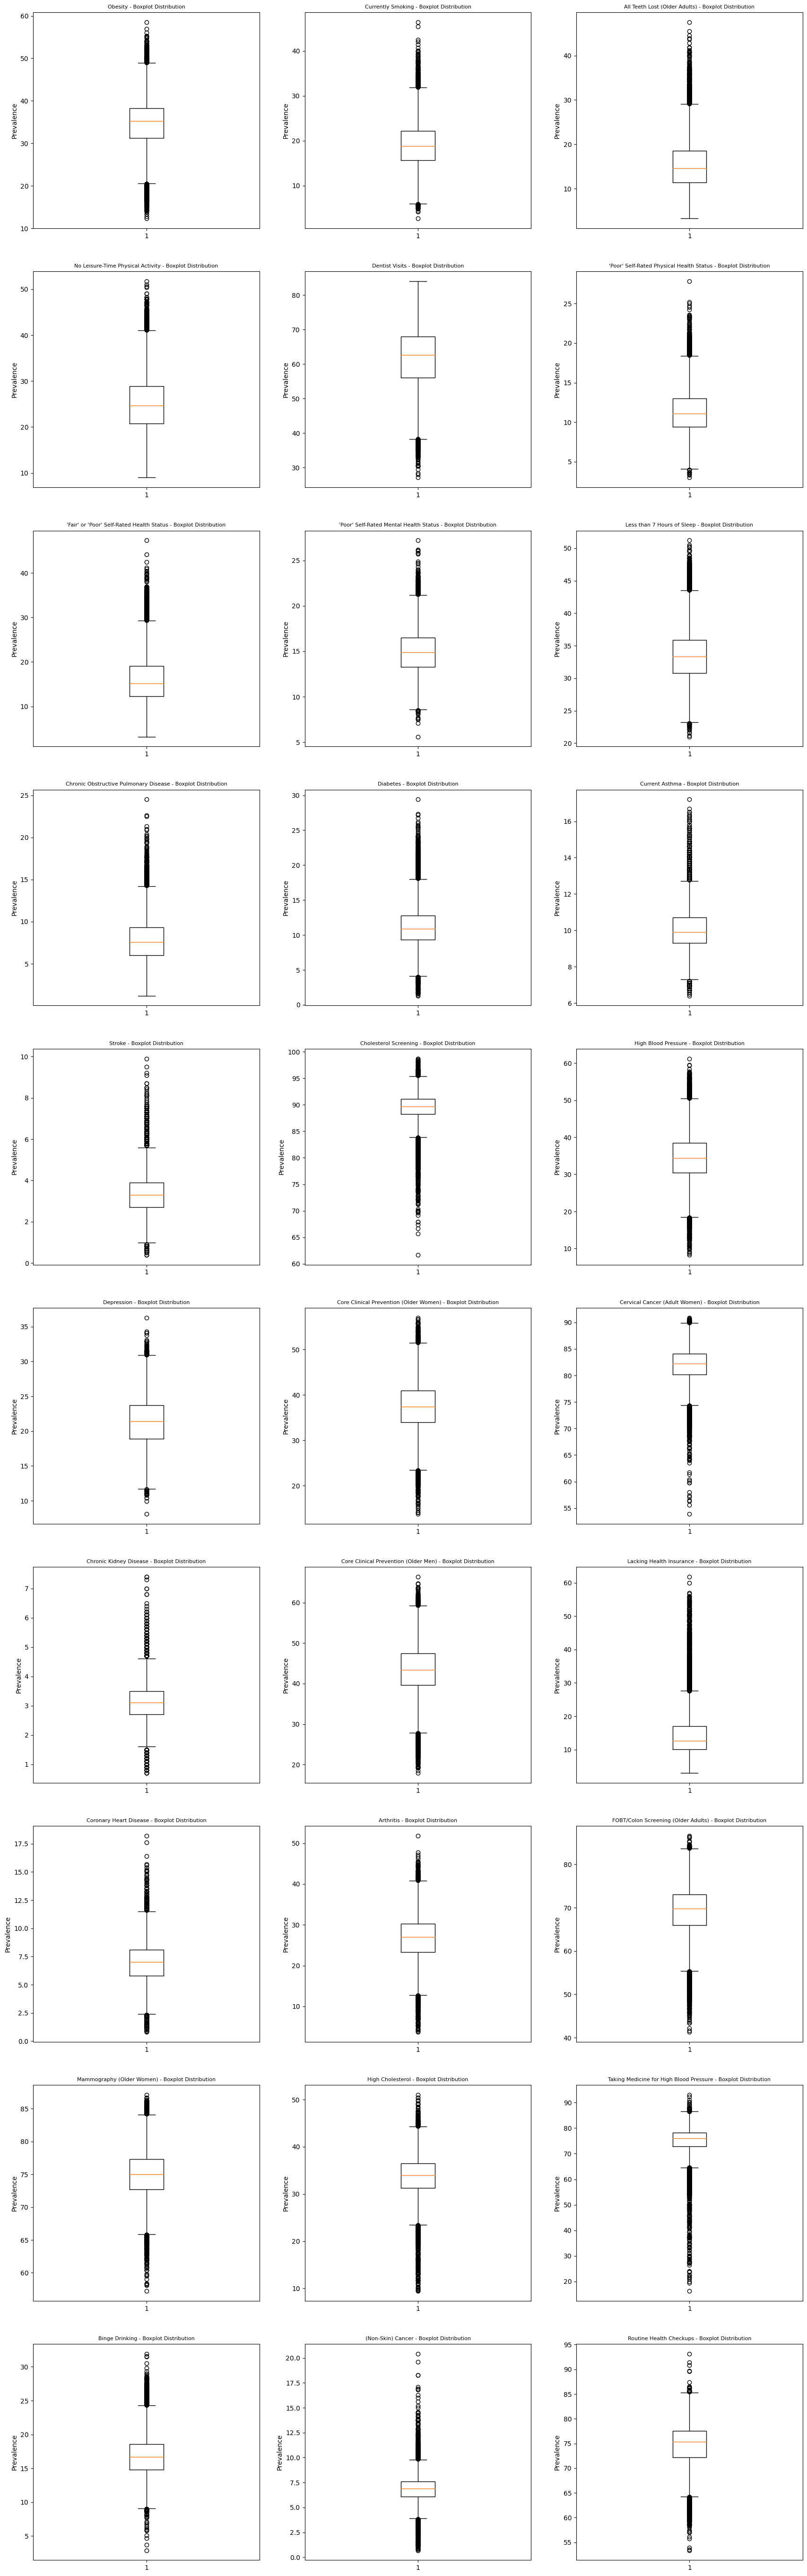

In [10]:
# Boxplots here

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[i*cols+j+1]
        axs[i, j].boxplot(medical_df[X])
        axs[i, j].set_title(f"{X} - Boxplot Distribution", fontdict={"fontsize":8})
        axs[i, j].set_ylabel("Prevalence")
plt.show()

Notably, there are quite a few outliers regardless of the dataset. However, in the grand scheme of things (especially when you try the histographic visualization of the data), the data is reasonably normally distributed. Given that the data is measured in terms of prevalence, no individual data point is so outrageous that it should be removed from consideration.

We would like to point out some of the boxplots of note, however:
- ZIP Codes with residents lacking health insurance coverage seemed to range from near 0% to over 60%. Similarly, high blood pressure medication prevalence ranges from 90% to below 20%. Given the wealth disparity of this nation, it wouldn't be unreasonable to suspect that average income is associated with distributions of health phenomena involving transactions and pharmaceutical administration, especially when considering the price of healthcare in this country.
- Stroke and chronic kidney disease prevalences seem to be relatively consistent given their lack of range. None of us are medical professionals, but perhaps the range of distributions in our dependent variables is a good sign of whether the correlations we're looking for will be strong or not.
- Thankfully, it does seem that the median prevalence for routine health checkups and many other screenings are reasonably high. At least people will be able to look at the bill and figure out what doomed them to a life of medical debt.

<a id="EDA1-4"></a>
### Outlier Control

In our exploratory data analysis of our Wealth independent variable, we noticed how skewed the distribution is. Since we would like to do linear regression, a model highly affected by outliers, in order to analyze our data, we'll need to decide what to do with data points we find to be undesirable.

In [11]:
# Define a function to create Linear Regression plots because this is a mouthful
# Takes in independent and dependent variables as series and spits back out a linear regression equation
# As we'll be needing Pearson-R stuff, it's in our best interest to use the more unruly SciPy method
def reg_this(x, y):
    result = linregress(x, y)
    
    # Access values with reg_this(x,y).slope, .intercept, .rvalue (Pearson-R), .pvalue (Hypothesis test for statistical significance of discovered regression), .stderr (Standard Error)
    return result

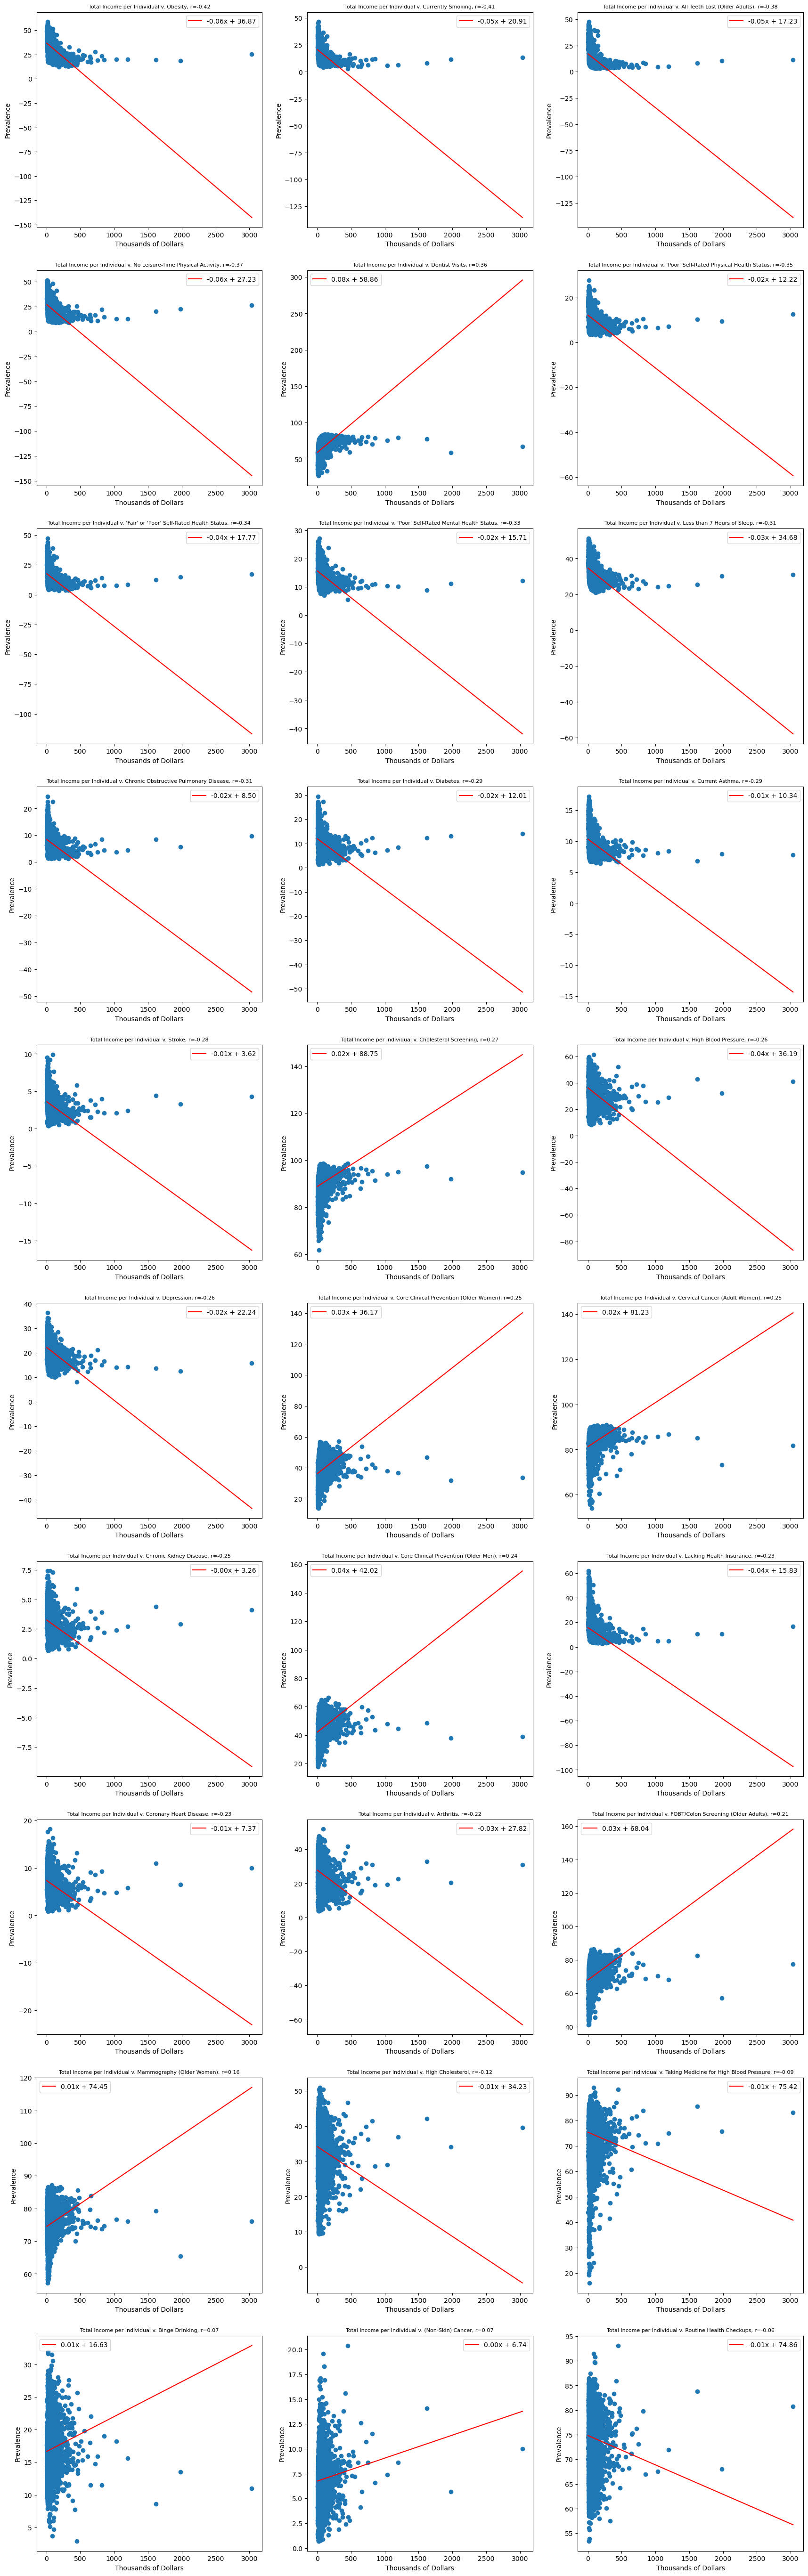

In [12]:
# Results indicate that we have to remove outliers for the charts to make sense, probably
# Results not necessarily best represented by linear models of regression

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)

# strength is a Pandas Series extracted from a correlation table we generated
# As a result, strength.index is an array of variable column names extracted from that series
# strength.index[0] is the independent variable, strength.index[everything else] are the dependent variables

# We'll iteratively compare our Wealth variable with all of the Health variables to see what we can assume at first glance
for i in range(rows):
    for j in range(cols):
        X = strength.index[0]
        Y = strength.index[i*cols+j+1]
        result = reg_this(medical_df[X], medical_df[Y])
        axs[i, j].scatter(medical_df[X], medical_df[Y])
        axs[i, j].plot(medical_df[X], (result.slope*medical_df[X]+result.intercept), label = f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")
        axs[i, j].set_title(f"{X} v. {Y}, r={result.rvalue:.2f}", fontdict={"fontsize":8})
        axs[i, j].set_xlabel("Thousands of Dollars")
        axs[i, j].set_ylabel("Prevalence")
        axs[i, j].legend(loc="best")
plt.savefig("Results/unculled_regressions_WealthvHealth.png")
plt.show()

At a glance, one could probably dismiss everything by saying that Wealth doesn't affect Health due to the weak to nonexistent correlation they have with each other, but the pictures themselves are noticably off. It's very obvious to see that every single regression chart here is disproprtionately affected by the data of the outliers especially with just how rich the richest ZIP Codes are. For that reason, we've decided to cull the outliers.

In [13]:
# ub is the upper bound defined by the 1.5xIQR Rule way back in the Wealth Check subsection
# We decided to drop about 10% of the data here
# We have considered assigning them as the average, but decided to drop it entirely
culled_df = medical_df.loc[medical_df["Total Income per Individual"] <= ub]
culled_df.to_csv("Resources/AGI+medical_data.csv")

# Correlation Table here
# Columns I'm interested in: any columns with a correlation coefficient of >0.6 

culled_corr_table = culled_df.drop(labels=["STATE", "ZIPCODE", "Total Individuals", "Total Income Amount", "lng", "lat"], axis="columns").corr(method='pearson')

# Ordered by strength of correlation (absolute value used). Note that none of the correlations here are stronger than 0.5
# However, because there could still be the chance that none of the graphs are LINEARLY correlated, it's still important to graph them somewhere and see if there are other relationships that make sense

culled_strength = corr_table.loc[:, "Total Income per Individual"].abs().sort_values(ascending=False)

#NOTE: The .abs() function is called. These are absolute values of correlations, not the correlations themselves

culled_r2 = (corr_table.loc[:, "Total Income per Individual"]**2).sort_values(ascending=False)

In [14]:
# Our dataset without the outliers
culled_df

STATE  ZIPCODE  Total Individuals  Total Income Amount  \
0        MS    38738              140.0         5.770000e+02   
1        MO    64147              280.0         1.591000e+03   
2        SD    57794              390.0         3.206000e+03   
3        TN    37140              390.0         3.239000e+03   
4        MT    59444              270.0         2.321000e+03   
...     ...      ...                ...                  ...   
25276    TX    76132            21060.0         1.310407e+06   
25277    MN    55442            12270.0         7.637550e+05   
25278    WA    98236             5480.0         3.414830e+05   
25279    CT     6333             7510.0         4.680000e+05   
25280    NY    10009            41230.0         2.569360e+06   

       Total Income per Individual        lng       lat  \
0                         4.121429  -90.53653  33.93049   
1                         5.682143  -94.54688  38.85387   
2                         8.220513 -102.40695  43.12071   
3                         8.305128  -87.65245  35.86345   
4                         8.596297 -111.34881  48.65227   
...                            ...        ...       ...   
25276                    62.222555  -97.41827  32.66743   
25277                    62.245721  -93.42690  45.04856   
25278                    62.314416 -122.40468  47.95804   
25279                    62.316911  -72.24527  41.38602   
25280                    62.317730  -73.97865  40.72639   

       Lacking Health Insurance  Arthritis  Binge Drinking  ...  \
0                          32.1       18.5            17.6  ...   
1                          19.1        9.0            21.1  ...   
2                          20.0       24.0            19.7  ...   
3                          27.6       17.0            19.5  ...   
4                          15.2       26.5            22.4  ...   
...                         ...        ...             ...  ...   
25276                      19.6       19.0            17.0  ...   
25277                       7.5       18.4            21.1  ...   
25278                       7.6       29.8            15.3  ...   
25279                       6.6       23.2            16.1  ...   
25280                      13.1       15.4            19.9  ...   

       High Cholesterol  Chronic Kidney Disease  \
0                  28.1                     2.6   
1                  13.2                     1.2   
2                  24.3                     4.4   
3                  25.8                     2.0   
4                  31.6                     3.0   
...                 ...                     ...   
25276              33.4                     2.4   
25277              28.2                     2.1   
25278              35.5                     3.0   
25279              33.9                     2.4   
25280              29.1                     2.5   

       No Leisure-Time Physical Activity  Mammography (Older Women)  \
0                                   33.0                       79.5   
1                                   22.9                       81.3   
2                                   38.5                       73.4   
3                                   28.5                       70.0   
4                                   23.5                       70.1   
...                                  ...                        ...   
25276                               19.9                       76.4   
25277                               13.4                       77.3   
25278                               15.5                       74.0   
25279                               15.4                       81.4   
25280                               21.6                       78.7   

       'Poor' Self-Rated Mental Health Status  Obesity  \
0                                        15.5     49.2   
1                                        21.9     31.9   
2                                        20.0     45.5   
3                        

<a id="INS1-1"></a>
## Insights

The unculled dataset had correlation strengths ranging from roughly 0.4 to 0.05. Hopefully, by removing the outliers, we can get more substantial results.

### Correlation Table

In [15]:
culled_corr_table

Total Income per Individual  \
Total Income per Individual                                   1.000000   
Lacking Health Insurance                                     -0.457592   
Arthritis                                                    -0.324625   
Binge Drinking                                                0.282079   
High Blood Pressure                                          -0.464203   
Taking Medicine for High Blood Pressure                      -0.122629   
(Non-Skin) Cancer                                             0.121030   
Current Asthma                                               -0.441040   
Cervical Cancer (Adult Women)                                 0.489705   
Coronary Heart Disease                                       -0.422868   
Routine Health Checkups                                      -0.093917   
Cholesterol Screening                                         0.427657   
FOBT/Colon Screening (Older Adults)                           0.389182   
Chronic Obstructive Pulmonary Disease                        -0.546018   
Core Clinical Prevention (Older Men)                          0.491832   
Core Clinical Prevention (Older Women)                        0.501970   
Currently Smoking                                            -0.671511   
Dentist Visits                                                0.695409   
Depression                                                   -0.345737   
Diabetes                                                     -0.574252   
'Fair' or 'Poor' Self-Rated Health Status                    -0.680209   
High Cholesterol                                             -0.213135   
Chronic Kidney Disease                                       -0.506237   
No Leisure-Time Physical Activity                            -0.697821   
Mammography (Older Women)                                     0.202953   
'Poor' Self-Rated Mental Health Status                       -0.564301   
Obesity                                                      -0.613062   
'Poor' Self-Rated Physical Health Status                     -0.660658   
Less than 7 Hours of Sleep                                   -0.510790   
Stroke                                                       -0.543893   
All Teeth Lost (Older Adults)                                -0.713790   

                                           Lacking Health Insurance  \
Total Income per Individual                               -0.457592   
Lacking Health Insurance                                   1.000000   
Arthritis                                                 -0.118729   
Binge Drinking                                            -0.251924   
High Blood Pressure                                        0.224215   
Taking Medicine for High Blood Pressure                   -0.122224   
(Non-Skin) Cancer                                         -0.404902   
Current Asthma                                             0.057255   
Cervical Cancer (Adult Women)                             -0.601483   
Coronary Heart Disease                                     0.109951   
Routine Health Checkups                                   -0.174335   
Cholesterol Screening                                     -0.427313   
FOBT/Colon Screening (Older Adults)                       -0.496464   
Chronic Obstructive Pulmonary Disease                      0.164887   
Core Clinical Prevention (Older Men)                      -0.495978   
Core Clinical Prevention (Older Women)                    -0.494309   
Currently Smoking                                          0.313078   
Dentist Visits                                            -0.734090   
Depression                                                 0.081600   
Diabetes                                                   0.496308   
'Fair' or 'Poor' Self-Rated Health Status                  0.619379   
High Cholesterol                                           0.022745   
Chronic Kidney Disease                   

In [16]:
# Once again, this is generated by taking the absolute value of every correlation with our Wealth variable
# The results are ordered by the "strength" of the correlations in order to see what has "any" relationship at all
culled_strength

Total Income per Individual                  1.000000
Obesity                                      0.418869
Currently Smoking                            0.414348
All Teeth Lost (Older Adults)                0.377696
No Leisure-Time Physical Activity            0.374376
Dentist Visits                               0.363755
'Poor' Self-Rated Physical Health Status     0.350397
'Fair' or 'Poor' Self-Rated Health Status    0.339200
'Poor' Self-Rated Mental Health Status       0.329701
Less than 7 Hours of Sleep                   0.308978
Chronic Obstructive Pulmonary Disease        0.306645
Diabetes                                     0.290737
Current Asthma                               0.285666
Stroke                                       0.279330
Cholesterol Screening                        0.273193
High Blood Pressure                          0.258748
Depression                                   0.256215
Core Clinical Prevention (Older Women)       0.251306
Cervical Cancer (Adult Women

The correlation strengths after removing the outliers has shot up to a range between 0.7 to 0.09, which is a lot more informative than the unfiltered data that suggested correlations between Wealth and Health were weak or nonexistent across the board.

Almost half of the correlations had a strength of above 0.5 with a frew of them being stronger than 0.6. An example is Wealth vs. Obesity with an r-score of -0.61, suggesting that ZIP Codes generally suffered less from obesity as they earned more income, which matches up with internet research as the cheapest consumable goods in America are generally also the most fattening and unhealthy products people can consume from a dietary perspective. Similarly, correlations with the "All Teeth Lost" and "Dental Visits" category were -0.71 and 0.69, respectively, as the more money you have, the higher chance you can afford proper dental care, consequently increasing your chances of preserving your teeth well into old age.

Generally, it does seem as if income has some kind of connection with most health outcomes, but there are some exceptions worth looking into. In particular, "Binge Drinking" has a weak *positive* correlation at 0.28, suggesting that, generally, a fixed portion of the population drinks beyond medically acceptable levels, though generally being able to afford booze means a higher tendency of consuming it. Perhaps this is due to drinking culture in the US and how drinking is a socially acceptable, if not coerced, activity or how stress is what drives people to drinking. "(Non-Skin) Cancer" also has a low correlation value at 0.12 as if to suggest that life happens and death is out to get you regardless of the thickness of your wallet.

In [17]:
# A quick check with this function shows that all correlation strengths above are statistically significant due to their near non-existent two-tailed p-values across all comparisons

for i in culled_strength.index:
    print(f"{i}, {reg_this(culled_df[culled_strength.index[0]], culled_df[i]).pvalue}")

Total Income per Individual, 0.0
Obesity, 0.0
Currently Smoking, 0.0
All Teeth Lost (Older Adults), 0.0
No Leisure-Time Physical Activity, 0.0
Dentist Visits, 0.0
'Poor' Self-Rated Physical Health Status, 0.0
'Fair' or 'Poor' Self-Rated Health Status, 0.0
'Poor' Self-Rated Mental Health Status, 0.0
Less than 7 Hours of Sleep, 0.0
Chronic Obstructive Pulmonary Disease, 0.0
Diabetes, 0.0
Current Asthma, 0.0
Stroke, 0.0
Cholesterol Screening, 0.0
High Blood Pressure, 0.0
Depression, 0.0
Core Clinical Prevention (Older Women), 0.0
Cervical Cancer (Adult Women), 0.0
Chronic Kidney Disease, 0.0
Core Clinical Prevention (Older Men), 0.0
Lacking Health Insurance, 0.0
Coronary Heart Disease, 0.0
Arthritis, 0.0
FOBT/Colon Screening (Older Adults), 0.0
Mammography (Older Women), 1.704167615921727e-229
High Cholesterol, 1.970670425184854e-253
Taking Medicine for High Blood Pressure, 6.064149884076212e-84
Binge Drinking, 0.0
(Non-Skin) Cancer, 8.39730953783134e-82
Routine Health Checkups, 7.6286747

In [18]:
culled_r2

Total Income per Individual                  1.000000
Obesity                                      0.175451
Currently Smoking                            0.171684
All Teeth Lost (Older Adults)                0.142654
No Leisure-Time Physical Activity            0.140157
Dentist Visits                               0.132318
'Poor' Self-Rated Physical Health Status     0.122778
'Fair' or 'Poor' Self-Rated Health Status    0.115057
'Poor' Self-Rated Mental Health Status       0.108703
Less than 7 Hours of Sleep                   0.095467
Chronic Obstructive Pulmonary Disease        0.094031
Diabetes                                     0.084528
Current Asthma                               0.081605
Stroke                                       0.078026
Cholesterol Screening                        0.074634
High Blood Pressure                          0.066951
Depression                                   0.065646
Core Clinical Prevention (Older Women)       0.063155
Cervical Cancer (Adult Women

The R-squared statistical measure represents the proportion of the variance of the dependent variable that's explained by the independent variable. Similar to our previous observations, it does seem as if Wealth explains for a good proportion of the variation in health outcomes such as obesity, smoking prevalence, and proper dental care. It's also highly apparent that there are other factors we haven't considered that affect the prevalence of cancer, high cholesterol, and arthritis in different communities.

It's important to realize that correlation **does not** imply causation. All we have found here is that there are associations between our arbitrary definition of wealth and some aspects of health. We cannot be certain of the direction of causality or if there's even causality between the variables discussed. However, the fact these associations even exist is already interesting enough to promote further discussion.

<a id="INS1-2"></a>
### Linear Regressions

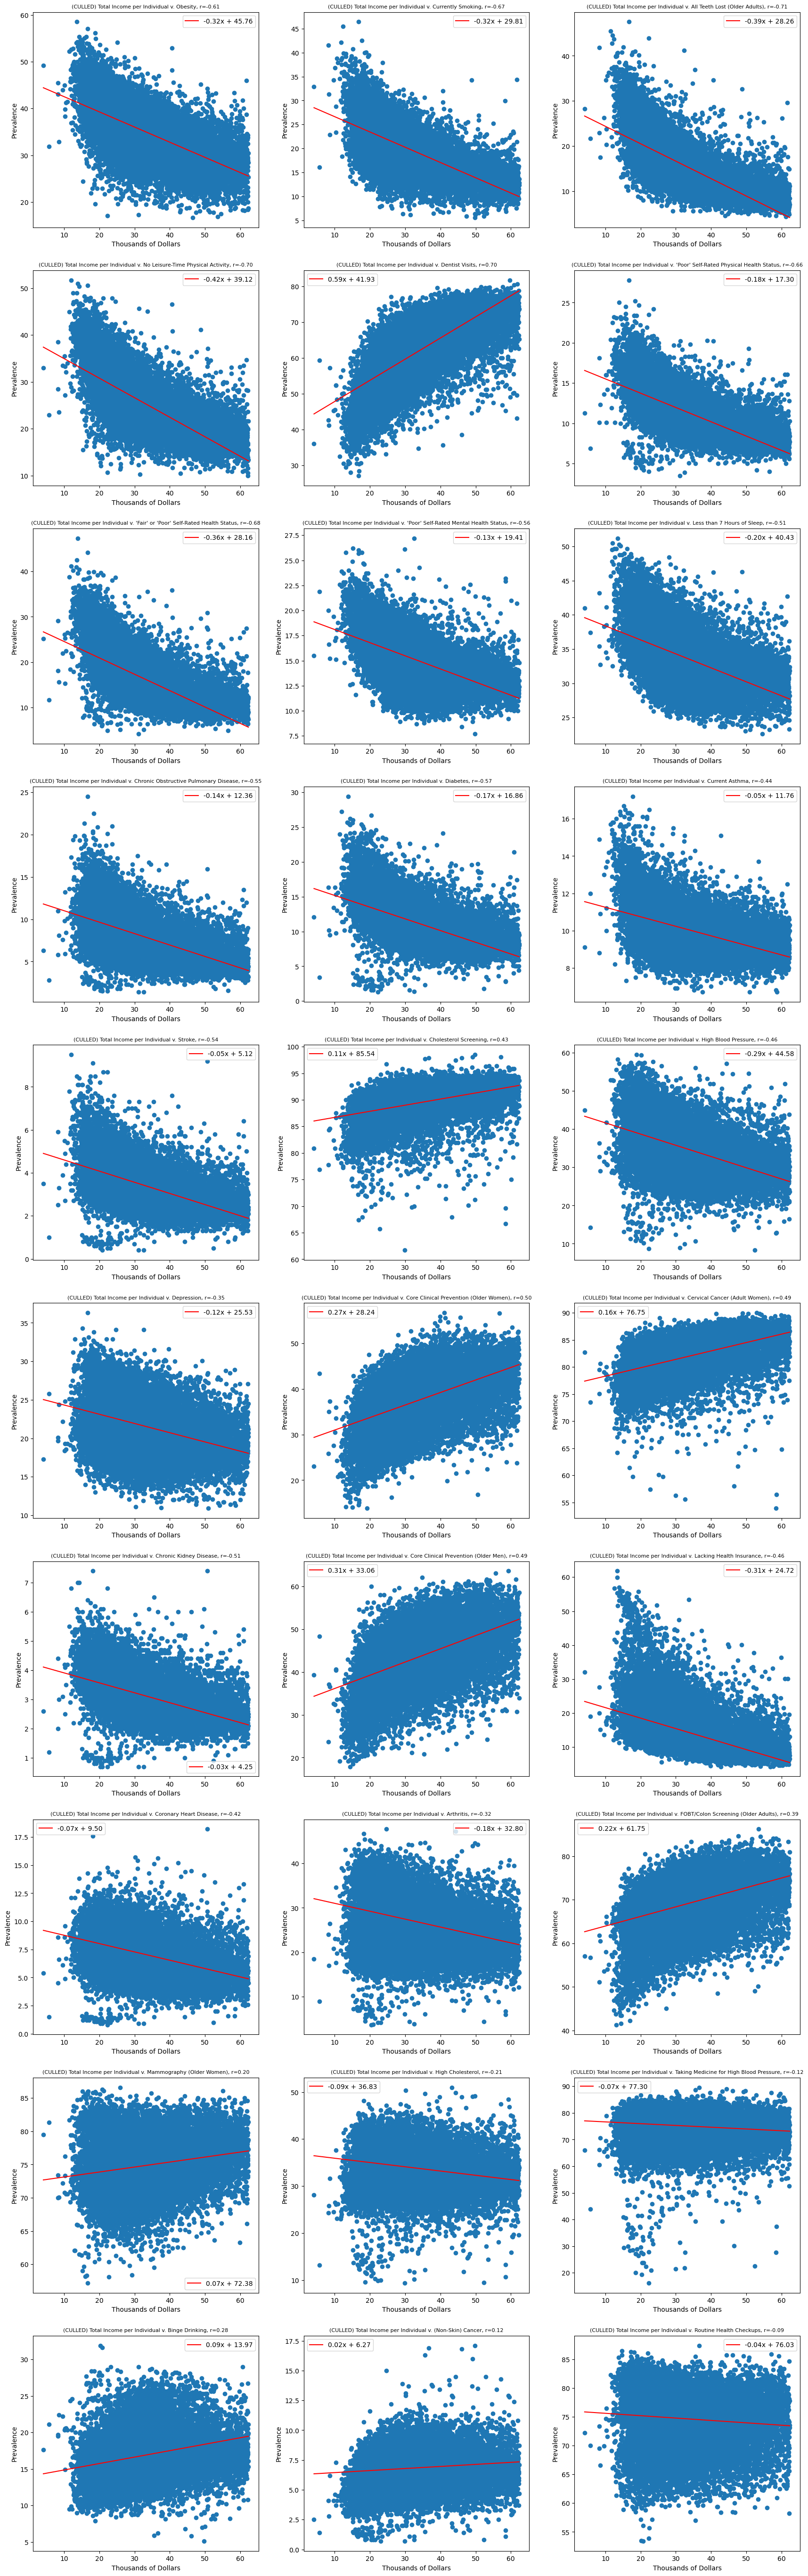

In [19]:
# Results indicate that we have to remove outliers for the charts to make sense, probably
# Results not necessarily best represented by linear models of regression

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(7*rows)
fig.set_figwidth(7*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[0]
        Y = strength.index[i*cols+j+1]
        result = reg_this(culled_df[X], culled_df[Y])
        axs[i, j].scatter(culled_df[X], culled_df[Y])
        axs[i, j].plot(culled_df[X], (result.slope*culled_df[X]+result.intercept), label = f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")
        axs[i, j].set_title(f"(CULLED) {X} v. {Y}, r={result.rvalue:.2f}", fontdict={"fontsize":8})
        axs[i, j].set_xlabel("Thousands of Dollars")
        axs[i, j].set_ylabel("Prevalence")
        axs[i, j].legend(loc="best")
plt.savefig("Results/culled_regressions_WealthvHealth.png")
plt.show()

Through the graphs produced, we can see the extent to which our Wealth variable is a contributing factor to various aspects of health. For example, the linear regression graph between "Total Income per Individual" and "No Leisure Time Physical Activity" predicts that for every $2.4 thousand increase in average total income per capita in a given ZIP Code, the prevalence of people not having time for exercise decreases by 1\%. "Time is money" and a surplus of money definitely affords you the time to do that kind of stuff. Similarly, the more money the average person somewhere has, the more likely they'll have dental visits.

For many of the Health variables, Wealth does seem to be a potent predictor, though there were still surprises like cancer that appeared.

<a id="INS1-3"></a>
### Geographic Visualizations

Sometimes, the results are just more easily shown than described.

In [20]:
# Small Corr-Strength Example

# Plug in desired column in X, your max point size in Y, and the scope of your map in Range
X = "(Non-Skin) Cancer"
Y = 300

test_df = culled_df.sort_values(X, ascending=False)[["Total Income per Individual", "STATE", X, "lng","lat"]]

# This is just here so people can see the correlation coefficient conveniently
result = reg_this(test_df["Total Income per Individual"], test_df[X])

# State-level views are used because a full nationwide view typically lags too much
# You can use "test_df.loc[~test_df["STATE"].isin(["AK","HI"])]" to see the mainland
# You can use something like "test_df = test_df.loc[test_df["STATE"]=="NY"]" to see a single state
test_df = test_df.loc[~test_df["STATE"].isin(["AK","HI"])]

# A new column is created such that the bigger prevalences are scaled closer to Max Point Size Y while the smaller points are scaled closer to 0
# This accentuates the differences in point size for the purposes of these visualizations
test_df["Scaled"] = (test_df[X]-test_df[X].min()+0.01)**math.log(Y, test_df[X].max()-test_df[X].min())

money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    color = "Total Income per Individual",
    alpha = .7,
    colorbar = True,
    size = "Scaled",
    xlabel="Longitude",
    ylabel="Latitude",
    title= f"(CULLED) ZIPCODES by MONEY (Color) and {X} (Size), r={result.rvalue:.2f}"
)

print(f"{X} Prevalence from {test_df[X].max()} to {test_df[X].min()}")
money_plot

(Non-Skin) Cancer Prevalence from 17.1 to 0.7


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual,Scaled)

With weaker correlations, the dots on the map seem more chaotic and noisy. There are both rich cities with high prevalence and rich cities with low prevalence. There are both lower-income cities with high prevalence and lower-income cities with low prevalence. At a glance, maps like these help show what kind of phenomena are tied to Wealth.

In [21]:
# Big Corr-Strength Example

# Plug in desired column in X, your max point size in Y, and the scope of your map in Range
X = "Obesity"
Y = 500

test_df = culled_df.sort_values(X, ascending=False)[["Total Income per Individual", "STATE", X, "lng","lat"]]

# This is just here so people can see the correlation coefficient conveniently
result = reg_this(test_df["Total Income per Individual"], test_df[X])

# State-level views are used because a full nationwide view typically lags too much
# You can use "test_df.loc[~test_df["STATE"].isin(["AK","HI"])]" to see the mainland
# You can use something like "test_df = test_df.loc[test_df["STATE"]=="NY"]" to see a single state
test_df = test_df.loc[test_df["STATE"]=="NY"]

# A new column is created such that the bigger prevalences are scaled closer to Max Point Size Y while the smaller points are scaled closer to 0
# This accentuates the differences in point size for the purposes of these visualizations
test_df["Scaled"] = (test_df[X]-test_df[X].min()+0.01)**math.log(Y, test_df[X].max()-test_df[X].min())

money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    color = "Total Income per Individual",
    alpha = .7,
    colorbar = True,
    size = "Scaled",
    xlabel="Longitude",
    ylabel="Latitude",
    title= f"(CULLED) ZIPCODES by MONEY (Color) and {X} (Size), r={result.rvalue:.2f}"
)

print(f"{X} Prevalence from {test_df[X].max()} to {test_df[X].min()}")
money_plot

Obesity Prevalence from 46.9 to 17.3


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual,Scaled)

With stronger correlations, patterns seem to form. Generally, bigger dots have a certain color while smaller dots have a different color. When viewed from a geographical perspective, it can be seen that high-income metropolis have different health outcomes from their lower-earning surroundings.

<a id='DC2'></a>
# Question 2: Do richer places have better housing conditions?

## Data Cleaning

In [87]:
# Store filepath in a variable
iou_utility = Path("Resources/iou_zipcodes_2020.csv")
non_iou_utility = Path("Resources/non_iou_zipcodes_2020.csv")
lat_long = Path("Resources/AGI+coords_data.csv")

# Read our data file with the Pandas library
iou_utility_df = pd.read_csv(iou_utility)
non_iou_utility_df = pd.read_csv(non_iou_utility)
lat_long_df = pd.read_csv(lat_long)

In [88]:
# Display iou data 
# IOU stands for Investor-Owned Utilities
# These are corporate utilities 
iou_utility_df.head()

zip  eiaid        utility_name state service_type       ownership  \
0  85321    176  Ajo Improvement Co    AZ      Bundled  Investor Owned   
1  36560    195    Alabama Power Co    AL      Bundled  Investor Owned   
2  36513    195    Alabama Power Co    AL      Bundled  Investor Owned   
3  36280    195    Alabama Power Co    AL      Bundled  Investor Owned   
4  35473    195    Alabama Power Co    AL      Bundled  Investor Owned   

   comm_rate  ind_rate  res_rate  
0   0.087890  0.000000  0.093887  
1   0.121895  0.063652  0.135057  
2   0.121895  0.063652  0.135057  
3   0.121895  0.063652  0.135057  
4   0.121895  0.063652  0.135057

In [89]:
# Drop service type = delivery 
# I kept Bundled because that indicates the full cost of a kWh of electricity
# Whereas Delivery is for where the consumer is sourcing energy from a party other than the utility iself
# And only pay to use the utility infrastructure 
# However, this is not an option available to all electricity markets in the US
# So, only some zipcodes will have Delivery as an option while others won't
# Therefore, it makes sense to keep Bundled and not Delivery 
iou_new = iou_utility_df.loc[iou_utility_df["service_type"]=="Bundled"]

# Remove unnecessary columns 
# eiaid is not used in this analysis 
# comm_rate indicates commercial rate and ind_rate indicates industrial rate
# I am keeping res_rate for residential rate which is applicable in this analysis comparing individual income and energy charge (unit $ per kWh)
iou_new.pop('eiaid')
iou_new.pop('comm_rate')
iou_new.pop('ind_rate')

# Rename zip column to match other csv file for merging purposes 
iou_new = iou_new.rename(columns = {'zip' :'ZIPCODE'})
iou_new.head()

ZIPCODE        utility_name state service_type       ownership  res_rate
0    85321  Ajo Improvement Co    AZ      Bundled  Investor Owned  0.093887
1    36560    Alabama Power Co    AL      Bundled  Investor Owned  0.135057
2    36513    Alabama Power Co    AL      Bundled  Investor Owned  0.135057
3    36280    Alabama Power Co    AL      Bundled  Investor Owned  0.135057
4    35473    Alabama Power Co    AL      Bundled  Investor Owned  0.135057

In [91]:
# Getting median values by grouping by zipcode
# There are zipcodes where there are more than one utilities
# I am cleaning the data to where one zipcode = one residential rate for data hygiene purposes 
iou_new = iou_new.groupby(['ZIPCODE']).median(numeric_only=True)
iou_new.head()

res_rate
ZIPCODE          
1002     0.240973
1005     0.240973
1007     0.240973
1009     0.240973
1010     0.240973

In [92]:
# Display non iou data 
# Non-IOU stands for Non-Investor-Owned Utilities 
# These utilities are membership cooperatives or small town municipalities
non_iou_utility_df.head()

zip  eiaid             utility_name state service_type    ownership  \
0  39730     55  City of Aberdeen - (MS)    MS      Bundled    Municipal   
1  38858     55  City of Aberdeen - (MS)    MS      Bundled    Municipal   
2  21864     84      A & N Electric Coop    MD      Bundled  Cooperative   
3  21824     84      A & N Electric Coop    MD      Bundled  Cooperative   
4  21866     84      A & N Electric Coop    MD      Bundled  Cooperative   

   comm_rate  ind_rate  res_rate  
0   0.106873  0.043796  0.112400  
1   0.106873  0.043796  0.112400  
2   0.127542  0.000000  0.127045  
3   0.127542  0.000000  0.127045  
4   0.127542  0.000000  0.127045

In [93]:
# Drop service type = delivery 
# I kept Bundled because that indicates the full cost of a kWh of electricity
# Whereas Delivery is for where the consumer is sourcing energy from a party other than the utility iself
# And only pay to use the utility infrastructure 
# However, this is not an option available to all electricity markets in the US
# So, only some zipcodes will have Delivery as an option while others won't
# Therefore, it makes sense to keep Bundled and not Delivery 
non_iou_new = non_iou_utility_df.loc[non_iou_utility_df["service_type"]=="Bundled"]

# Remove unnecessary columns 
# eiaid is not used in this analysis 
# comm_rate indicates commercial rate and ind_rate indicates industrial rate
# I am keeping res_rate for residential rate which is applicable in this analysis comparing individual income and energy charge (unit $ per kWh)
non_iou_new.pop('eiaid')
non_iou_new.pop('comm_rate')
non_iou_new.pop('ind_rate')

# Rename zip column to match other csv file for merging purposes
non_iou_new = non_iou_new.rename(columns = {'zip' :'ZIPCODE'})
non_iou_new.head()

ZIPCODE             utility_name state service_type    ownership  res_rate
0    39730  City of Aberdeen - (MS)    MS      Bundled    Municipal  0.112400
1    38858  City of Aberdeen - (MS)    MS      Bundled    Municipal  0.112400
2    21864      A & N Electric Coop    MD      Bundled  Cooperative  0.127045
3    21824      A & N Electric Coop    MD      Bundled  Cooperative  0.127045
4    21866      A & N Electric Coop    MD      Bundled  Cooperative  0.127045

In [95]:
# Getting median values by grouping by zipcode
# There are zipcodes where there are more than one utilities
# I am cleaning the data to where one zipcode = one residential rate for data hygiene purposes 
non_iou_new = non_iou_new.groupby(['ZIPCODE']).median(numeric_only=True)
non_iou_new.head()

res_rate
ZIPCODE          
501      0.212208
544      0.212208
1013     0.130938
1014     0.125910
1020     0.130938

In [96]:
# Display lat/long data

lat_long_df.head()

Unnamed: 0  index STATE  ZIPCODE     N2     A02650  \
0           0  12873    MS    38738  140.0   577.0000   
1           1  13576    MO    64147  280.0  1591.0000   
2           2  22399    SD    57794  390.0  3206.0000   
3           3  22477    TN    37140  390.0  3239.0001   
4           4  14171    MT    59444  270.0  2321.0001   

   Total Income per Individual        lng       lat  
0                     4.121429  -90.53653  33.93049  
1                     5.682143  -94.54688  38.85387  
2                     8.220513 -102.40695  43.12071  
3                     8.305128  -87.65245  35.86345  
4                     8.596297 -111.34881  48.65227

In [97]:
# Remove unnecessary columns
# The following columns are removed because they're not used in this analysis  
lat_long_df.pop('index')
lat_long_df.pop('N2')
lat_long_df.pop('A02650')

lat_long_df.head()

Unnamed: 0 STATE  ZIPCODE  Total Income per Individual        lng       lat
0           0    MS    38738                     4.121429  -90.53653  33.93049
1           1    MO    64147                     5.682143  -94.54688  38.85387
2           2    SD    57794                     8.220513 -102.40695  43.12071
3           3    TN    37140                     8.305128  -87.65245  35.86345
4           4    MT    59444                     8.596297 -111.34881  48.65227

In [100]:
# Merging with csv file that includes latitute and longitude for mapping purposes 
iou_merged = iou_new.merge(lat_long_df, on="ZIPCODE", how='inner')
iou_merged.dropna(axis = 'index', how = 'any', inplace = True)
iou_merged.head()

ZIPCODE  res_rate  Unnamed: 0 STATE  Total Income per Individual       lng  \
0     1002  0.240973       25131    MA                    60.517208 -72.46462   
1     1005  0.240973       18585    MA                    36.737611 -72.10655   
2     1007  0.240973       22412    MA                    44.968338 -72.40009   
3     1010  0.240973       22108    MA                    44.043855 -72.20597   
4     1012  0.240973       19464    MA                    38.033333 -72.84675   

        lat  
0  42.37633  
1  42.42117  
2  42.28163  
3  42.12904  
4  42.38495

In [101]:
# Merging with csv file that includes latitute and longitude for mapping purposes
non_iou_merged = non_iou_new.merge(lat_long_df, on="ZIPCODE", how='inner')
non_iou_merged.dropna(axis = 'index', how = 'any', inplace = True)
non_iou_merged.head()

ZIPCODE  res_rate  Unnamed: 0 STATE  Total Income per Individual       lng  \
0     1013  0.130938        8680    MA                    27.248507 -72.60788   
1     1020  0.130938       14791    MA                    32.324322 -72.56538   
2     1022  0.125910       16160    MA                    33.734524 -72.54249   
3     1027  0.135965       21427    MA                    42.081447 -72.74303   
4     1030  0.144544       21203    MA                    41.509041 -72.67967   

        lat  
0  42.16059  
1  42.17618  
2  42.19721  
3  42.29506  
4  42.06869

In [102]:
# Merging iou utilities and non iou utilities for t-test 
total_merged = non_iou_merged.merge(iou_merged, on = "ZIPCODE", how = 'inner')

# Drop unnecessary columns because they're either not needed for analysis or duplicates as the result of merging 
total_merged.pop('STATE_x')
total_merged.pop('STATE_y')
total_merged.pop('Total Income per Individual_x')
total_merged.pop('lng_x')
total_merged.pop('lat_x')
total_merged.pop('Unnamed: 0_x')
total_merged.pop('Unnamed: 0_y')


# Rename Columns 
total_merged = total_merged.rename(columns = {'res_rate_x':'non_iou_rate_per_kWh',
                                              'res_rate_y':'iou_rate_per_kWh',
                                              'Total Income per Individual_y':'Total Income per Individual',
                                              'lng_y':'lng',
                                              'lat_y':'lat'})
total_merged.head()

ZIPCODE  non_iou_rate_per_kWh  iou_rate_per_kWh  \
0     1027              0.135965          0.240973   
1     1033              0.125910          0.240973   
2     1056              0.125910          0.240973   
3     1062              0.135965          0.240973   
4     1075              0.130938          0.240973   

   Total Income per Individual       lng       lat  
0                    42.081447 -72.74303  42.29506  
1                    45.868547 -72.50361  42.26082  
2                    41.093951 -72.45805  42.19211  
3                    64.852547 -72.69244  42.32146  
4                    47.818835 -72.57928  42.25672

<a id='EDA2'></a>
## Exploratory Data Analysis

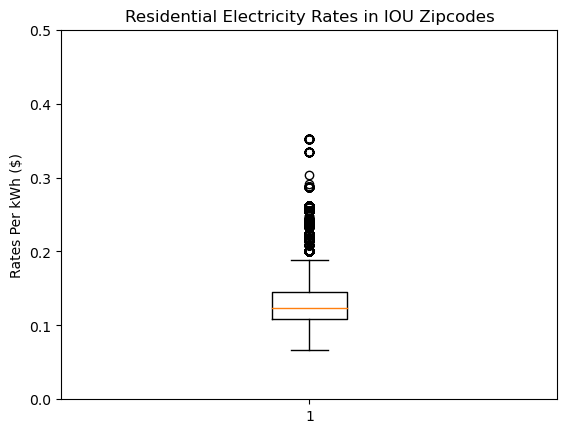

In [98]:
# Box plot for residential electricity rates in Invester-Owned Utilities 
# I chose a boxplot to see if there is a difference in pricing trends for Investor- and Non-Investor-Owned Utilities since the data sets I found differentiated between the two
# Outliers are anything above the $0.20 per kWh mark
# Minimum is around $0.05 per kWh while maximum is around $0.20 per kWh
res_rate = iou_new['res_rate']

fig1, ax1 = plt.subplots()
ax1.set_title('Residential Electricity Rates in IOU Zipcodes')
ax1.set_ylabel('Rates Per kWh ($)')
plt.ylim(0, 0.5)
ax1.boxplot(res_rate)
plt.show()

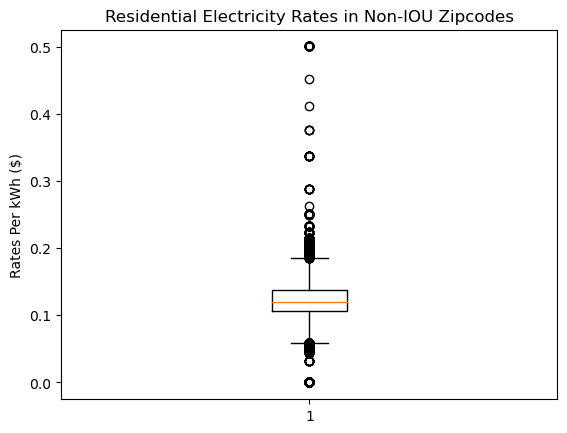

In [99]:
# Box plot for residential electricity rates in Non-Invester-Owned Utilities 
# I chose a boxplot to see if there is a difference in pricing trends for Investor- and Non-Investor-Owned Utilities since the data sets I found differentiated between the two
# Outliers are anything above the $0.20 per kWh mark and below the $0.05 per kWh mark
# Minimum is around $0.05 per kWh while maximum is around $0.20 per kWh
# The middle 50% seems to be within a shorter range compared to the boxplot for IOU Utilities 
non_iou_res_rate = non_iou_new['res_rate']

fig2, ax2 = plt.subplots()
ax2.set_title('Residential Electricity Rates in Non-IOU Zipcodes')
ax2.set_ylabel('Rates Per kWh ($)')
ax2.boxplot(non_iou_res_rate)
plt.show()

<a id='INS2'></a>
## Insights

In [104]:
# T-Test
# The boxplots showed that IOU and Non-IOU electricity rates have similar medians
# Does that mean they have the same mean as well?
# We can use a T-Test to find the answer statistically 
# The null is that the two populations have the same mean 
# The p-value is the probability of obtaining results assuming that the null hypothesis is correct
# Here, the p-value is less than 0.05
# Which means that we reject the null hypothesis that the two population means are equal 

st.ttest_ind(total_merged.non_iou_rate_per_kWh, total_merged.iou_rate_per_kWh, equal_var=False)

Ttest_indResult(statistic=-3.108875509983721, pvalue=0.0018805018095221677)

In [105]:
# Map showing income and residential electricity rates for IOUs
# Color indicates electricity rates
# Size of dots indicate income
energy_map1 = iou_merged.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 600,
    scale = 1,
    color = "res_rate",
    size = "Total Income per Individual",
    colorbar = True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "Income and Residential Electricity Rates for Investor-Owned Utilities"
)
energy_map1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (res_rate,Total Income per Individual)

In [106]:
# Map showing income and residential electricity rates for Non-IOUs
# Color indicates electricity rates
# Size of dots indicate income
energy_map2 = non_iou_merged.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 600,
    scale = 1,
    color = "res_rate",
    size = "Total Income per Individual",
    colorbar = True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "Income and Residential Electricity Rates for Non-Investor-Owned Utilities"
)
energy_map2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (res_rate,Total Income per Individual)

The r-squared is: 0.029536779118478212


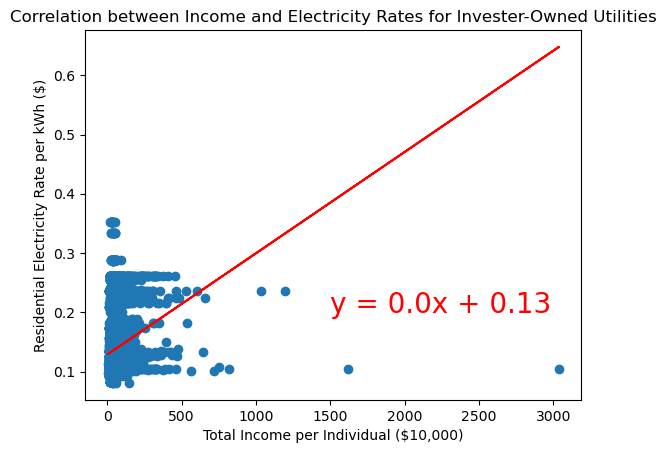

In [107]:
# Linear regression for Invester-Owned Utilities
# By looking at the map, it does not seem that there is a correlation between income and residential electricity rates
# We can confirm this by doing a linear regression with the data
# When the r-value is close to the extremes of the range -1 to 1, it means that there is a strong correlation
# My result shows the opposite of that, which proves that there is no correlation between income and residential electricity rates
# Per my anecdotal experience, this is correct
# Electricity rates are dictated by what's going on in their perspective Independent System Operator (ISO) markets within the US and not purely based off of income
# It would be interesting to see if income and electricity rates correlate within the same ISO

x_values = iou_merged['Total Income per Individual']
y_values = iou_merged['res_rate']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1500,0.2),fontsize=20,color="red")
plt.xlabel('Total Income per Individual ($10,000)')
plt.ylabel('Residential Electricity Rate per kWh ($)')
plt.title('Correlation between Income and Electricity Rates for Invester-Owned Utilities')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.01611620953974901


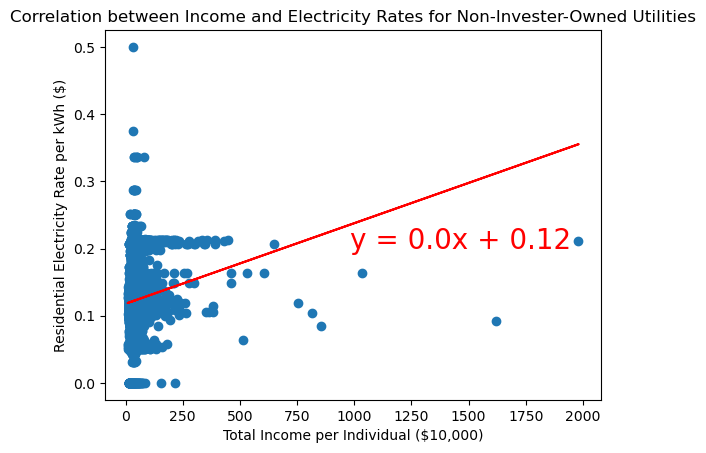

In [108]:
# Linear regression for Non-Invester-Owned Utilities
# By looking at the map, it does not seem that there is a correlation between income and residential electricity rates
# We can confirm this by doing a linear regression with the data
# When the r-value is close to the extremes of the range -1 to 1, it means that there is a strong correlation
# My result shows the opposite of that, which proves that there is no correlation between income and residential electricity rates
# Per my anecdotal experience, this is correct
# Electricity rates are dictated by what's going on in their perspective Independent System Operator (ISO) markets within the US and not purely based off of income
# It would be interesting to see if income and electricity rates correlate within the same ISO

x_values = non_iou_merged['Total Income per Individual']
y_values = non_iou_merged['res_rate']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(980,0.2),fontsize=20,color="red")
plt.xlabel('Total Income per Individual ($10,000)')
plt.ylabel('Residential Electricity Rate per kWh ($)')
plt.title('Correlation between Income and Electricity Rates for Non-Invester-Owned Utilities')
print(f"The r-squared is: {rvalue**2}")
plt.show()

<a id='DC4'></a>
# Question 4: Do richer places have better public order?

## Data Cleaning

In [65]:
# File to Load
wage_estimates_to_load = Path("Resources/May 2022 State Occupational Employment and Wage Estimates.csv")
crime_data_load = Path("Resources/estimated_crimes_1979_2020.csv")

# Read Data File and store into Pandas DataFrames
wage_estimates = pd.read_csv(wage_estimates_to_load)
crime_data = pd.read_csv(crime_data_load)

wage_estimates.head()

AREA AREA_TITLE  AREA_TYPE PRIM_STATE  NAICS     NAICS_TITLE  \
0     1    Alabama          2         AL      0  Cross-industry   
1     1    Alabama          2         AL      0  Cross-industry   
2     1    Alabama          2         AL      0  Cross-industry   
3     1    Alabama          2         AL      0  Cross-industry   
4     1    Alabama          2         AL      0  Cross-industry   

          I_GROUP  OWN_CODE OCC_CODE                        OCC_TITLE  ...  \
0  cross-industry      1235  00-0000                  All Occupations  ...   
1  cross-industry      1235  11-0000           Management Occupations  ...   
2  cross-industry      1235  11-1011                 Chief Executives  ...   
3  cross-industry      1235  11-1021  General and Operations Managers  ...   
4  cross-industry      1235  11-1031                      Legislators  ...   

  H_MEDIAN H_PCT75 H_PCT90 A_PCT10  A_PCT25  A_MEDIAN  A_PCT75  A_PCT90  \
0    18.50   28.94   43.25  21,580   28,030    38,470   60,190   89,950   
1    46.12   63.53   86.89  47,680   66,210    95,940  132,150  180,730   
2    65.83   90.64       #  50,920  108,470   136,930  188,530        #   
3    47.17   71.64  105.19  44,530   65,280    98,120  149,010  218,800   
4        *       *       *  17,080   18,130    20,320   35,730   57,060   

  ANNUAL HOURLY  
0    NaN    NaN  
1    NaN    NaN  
2    NaN    NaN  
3    NaN    NaN  
4   True    NaN  

[5 rows x 32 columns]

In [66]:
# Remove unwanted columms
wage_estimates_summary = wage_estimates[["PRIM_STATE", "OCC_TITLE", "H_MEAN", "A_MEAN", "H_MEDIAN","A_MEDIAN"]]
wage_estimates_summary


PRIM_STATE                                          OCC_TITLE H_MEAN  \
0             AL                                    All Occupations  24.34   
1             AL                             Management Occupations  53.13   
2             AL                                   Chief Executives  91.67   
3             AL                    General and Operations Managers  58.00   
4             AL                                        Legislators      *   
...          ...                                                ...    ...   
37564         VI             Industrial Truck and Tractor Operators  15.97   
37565         VI                 Cleaners of Vehicles and Equipment  13.98   
37566         VI  Laborers and Freight, Stock, and Material Move...  14.58   
37567         VI                        Packers and Packagers, Hand  13.35   
37568         VI                         Stockers and Order Fillers  13.00   

        A_MEAN H_MEDIAN A_MEDIAN  
0       50,620    18.50   38,470  
1      110,500    46.12   95,940  
2      190,680    65.83  136,930  
3      120,640    47.17   98,120  
4       30,000        *   20,320  
...        ...      ...      ...  
37564   33,210    15.15   31,520  
37565   29,080    13.92   28,950  
37566   30,320    13.73   28,550  
37567   27,770    12.59   26,180  
37568   27,040    12.76   26,540  

[37569 rows x 6 columns]

In [67]:
# Rename the columns
wage_estimates_summary = wage_estimates_summary.rename(columns={
    'PRIM_STATE': 'State',
    'OCC_TITLE': 'Occupation',
    'H_MEAN': 'Average hourly wage',
    'A_MEAN': 'Average annual wage',
    'H_MEDIAN': 'Median hourly wage',
    'A_MEDIAN': 'Median annual wage'
})

wage_estimates_summary.head()


State                       Occupation Average hourly wage  \
0    AL                  All Occupations               24.34   
1    AL           Management Occupations               53.13   
2    AL                 Chief Executives               91.67   
3    AL  General and Operations Managers               58.00   
4    AL                      Legislators                   *   

  Average annual wage Median hourly wage Median annual wage  
0              50,620              18.50             38,470  
1             110,500              46.12             95,940  
2             190,680              65.83            136,930  
3             120,640              47.17             98,120  
4              30,000                  *             20,320

In [68]:
# show only the rows related to Data Scientists
data_scientists = wage_estimates_summary[(wage_estimates_summary['Occupation'] == 'Data Scientists')]
data_scientists.head()

State       Occupation Average hourly wage Average annual wage  \
85      AL  Data Scientists               44.03              91,570   
815     AK  Data Scientists               49.91             103,810   
1390    AZ  Data Scientists               50.11             104,220   
2845    CA  Data Scientists               70.86             147,390   
3671    CO  Data Scientists               56.04             116,560   

     Median hourly wage Median annual wage  
85                41.29             85,870  
815               48.09            100,040  
1390              49.41            102,770  
2845              60.97            126,810  
3671              49.62            103,200

In [69]:
# Display the first few rows of the crime_data DataFrame
crime_data


year state_abbr          state_name  population  violent_crime  \
0     1979         AK              Alaska      406000           1994   
1     1979         AL             Alabama     3769000          15578   
2     1979         AR            Arkansas     2180000           7984   
3     1979         AZ             Arizona     2450000          14528   
4     1979         CA          California    22696000         184087   
...    ...        ...                 ...         ...            ...   
2137  2020         VT             Vermont      623347           1081   
2138  2020         WA          Washington     7693612          22596   
2139  2020         WI           Wisconsin     5832655          18861   
2140  2020         WV       West Virginia     1784787           6352   
2141  2020         WY             Wyoming      582328           1364   

      homicide  rape_legacy  rape_revised  robbery  aggravated_assault  \
0           54        292.0           NaN      445                1203   
1          496       1037.0           NaN     4127                9918   
2          198        595.0           NaN     1626                5565   
3          219       1120.0           NaN     4305                8884   
4         2952      12239.0           NaN    75767               93129   
...        ...          ...           ...      ...                 ...   
2137        14          NaN         213.0       64                 790   
2138       301          NaN        2677.0     5183               14435   
2139       308          NaN        2020.0     3081               13452   
2140       117          NaN         832.0      369                5034   
2141        18          NaN         333.0       66                 947   

      property_crime  burglary  larceny  motor_vehicle_theft caveats  \
0              23193      5616    15076                 2501     NaN   
1             144372     48517    83791                12064     NaN   
2              70949     21457    45267                 4225     NaN   
3             177977     48916   116976                12085     NaN   
4            1511021    496310   847148               167563     NaN   
...              ...       ...      ...                  ...     ...   
2137            7586       961     6361                  264     NaN   
2138          210223     40167   142657                27399     NaN   
2139           86654     12744    64517                 9393     NaN   
2140           24976      4877    17828                 2271     NaN   
2141            9379      1225     7190                  964     NaN   

      total_crimes  
0            50374  
1           319900  
2           157866  
3           385010  
4          3390216  
...            ...  
2137         17334  
2138        465638  
2139        211030  
2140         62656  
2141         21486  

[2142 rows x 16 columns]

In [70]:
# Filter the crime_data to select only the relevant columns

crime_summary = crime_data[["year", "state_abbr", "total_crimes"]]
crime_summary

year state_abbr  total_crimes
0     1979         AK         50374
1     1979         AL        319900
2     1979         AR        157866
3     1979         AZ        385010
4     1979         CA       3390216
...    ...        ...           ...
2137  2020         VT         17334
2138  2020         WA        465638
2139  2020         WI        211030
2140  2020         WV         62656
2141  2020         WY         21486

[2142 rows x 3 columns]

In [71]:
# Rename the columns
crime_summary = crime_summary.rename(columns={
    'year': 'Year',
    'state_abbr': 'State',
    'total_crimes': 'Total Crimes'
})

crime_summary.head()

Year State  Total Crimes
0  1979    AK         50374
1  1979    AL        319900
2  1979    AR        157866
3  1979    AZ        385010
4  1979    CA       3390216

In [72]:
# Filter the DataFrame to keep only the year 2020
crime_data_2020 = crime_summary[crime_summary['Year'] == 2020]


crime_data_2020

Year State  Total Crimes
2091  2020    AK         45308
2092  2020    AL        254966
2093  2020    AR        199126
2094  2020    AZ        402606
2095  2020    CA       2032160
2096  2020    CO        378304
2097  2020    CT        124258
2098  2020    DC         64052
2099  2020    DE         47234
2100  2020    FL        935848
2101  2020    GA        515676
2102  2020    HI         75008
2103  2020    IA        126652
2104  2020    ID         49490
2105  2020    IL        499798
2106  2020    IN        289228
2107  2020    KS        152924
2108  2020    KY        182546
2109  2020    LA        327386
2110  2020    MA        187780
2111  2020    MD        243404
2112  2020    ME         34152
2113  2020    MI        366548
2114  2020    MN        271820
2115  2020    MO        378166
2116  2020    MS        141978
2117  2020    MT         55988
2118  2020    NC        560954
2119  2020    ND         37548
2120  2020    NE         86928
2121  2020    NH         34028
2122  2020    NJ        240456
2123  2020    NM        152504
2124  2020    NV        149814
2125  2020    NY        686254
2126  2020    OH        504934
2127  2020    OK        251920
2128  2020    OR        250324
2129  2020    PA        519920
2130  2020    RI         31212
2131  2020    SC        339356
2132  2020    SD         43888
2133  2020    TN        436006
2134  2020    TX       1580488
2135  2020    UT        177124
2136  2020    VA        286078
2137  2020    VT         17334
2138  2020    WA        465638
2139  2020    WI        211030
2140  2020    WV         62656
2141  2020    WY         21486

In [73]:
# Merge the data_scientists DataFrame and the crime_data_2020 DataFrame based on the 'State' column
combined_data = pd.merge(data_scientists.replace(" ", ""), crime_data_2020.replace(" ", ""), on='State', how="left")
combined_data

State       Occupation Average hourly wage Average annual wage  \
0     AL  Data Scientists               44.03              91,570   
1     AK  Data Scientists               49.91             103,810   
2     AZ  Data Scientists               50.11             104,220   
3     CA  Data Scientists               70.86             147,390   
4     CO  Data Scientists               56.04             116,560   
5     CT  Data Scientists               52.99             110,220   
6     DE  Data Scientists               64.10             133,320   
7     DC  Data Scientists               52.98             110,190   
8     FL  Data Scientists               48.45             100,780   
9     GA  Data Scientists               51.16             106,400   
10    HI  Data Scientists               49.75             103,470   
11    ID  Data Scientists               45.92              95,520   
12    IL  Data Scientists               52.82             109,870   
13    IN  Data Scientists               37.93              78,890   
14    IA  Data Scientists               45.28              94,190   
15    KS  Data Scientists               45.63              94,920   
16    KY  Data Scientists               41.57              86,470   
17    LA  Data Scientists               34.48              71,710   
18    ME  Data Scientists               48.60             101,080   
19    MD  Data Scientists               57.19             118,960   
20    MA  Data Scientists               57.86             120,340   
21    MI  Data Scientists               44.62              92,820   
22    MN  Data Scientists               53.72             111,740   
23    MS  Data Scientists               31.70              65,940   
24    MO  Data Scientists               39.36              81,860   
25    MT  Data Scientists               35.93              74,720   
26    NE  Data Scientists               42.95              89,340   
27    NV  Data Scientists               46.57              96,870   
28    NH  Data Scientists               41.97              87,300   
29    NJ  Data Scientists               62.49             129,980   
30    NM  Data Scientists               41.87              87,090   
31    NY  Data Scientists               61.63             128,200   
32    NC  Data Scientists               57.67             119,960   
33    ND  Data Scientists               44.87              93,340   
34    OH  Data Scientists               44.27              92,080   
35    OK  Data Scientists               42.21              87,810   
36    OR  Data Scientists               53.41             111,090   
37    PA  Data Scientists               46.12              95,940   
38    RI  Data Scientists               56.53             117,570   
39    SC  Data Scientists               48.34             100,550   
40    SD  Data Scientists               52.13             108,430   
41    TN  Data Scientists               53.88             112,070   
42    TX  Data Scientists               49.15             102,230   
43    UT  Data Scientists               42.63              88,660   
44    VT  Data Scientists                   *                   *   
45    VA  Data Scientists               64.42             133,990   
46    WA  Data Scientists               67.68             140,780   
47    WV  Data Scientists               34.88              72,550   
48    WI  Data Scientists               43.63              90,760   
49    WY  Data Scientists               61.95             128,860   
50    PR  Data Scientists               31.21              64,910   

   Median hourly wage Median annual wage    Year  Total Crimes  
0               41.29             85,870  2020.0      254966.0  
1               48.09            100,040  2020.0       45308.0  
2               49.41            102,770  2020.0      402606.0  
3               60.97            126,810  2020.0     2032160.0  
4               49.62            103,200  2020.0      378304.0  
5               50.82   

In [74]:
# Replace non-numeric values with NaN
combined_data = combined_data.replace('*', np.nan)

In [75]:
# Drop rows with missing values
combined_data_clean = combined_data.dropna()
combined_data_clean

State       Occupation Average hourly wage Average annual wage  \
0     AL  Data Scientists               44.03              91,570   
1     AK  Data Scientists               49.91             103,810   
2     AZ  Data Scientists               50.11             104,220   
3     CA  Data Scientists               70.86             147,390   
4     CO  Data Scientists               56.04             116,560   
5     CT  Data Scientists               52.99             110,220   
6     DE  Data Scientists               64.10             133,320   
7     DC  Data Scientists               52.98             110,190   
8     FL  Data Scientists               48.45             100,780   
9     GA  Data Scientists               51.16             106,400   
10    HI  Data Scientists               49.75             103,470   
11    ID  Data Scientists               45.92              95,520   
12    IL  Data Scientists               52.82             109,870   
13    IN  Data Scientists               37.93              78,890   
14    IA  Data Scientists               45.28              94,190   
15    KS  Data Scientists               45.63              94,920   
16    KY  Data Scientists               41.57              86,470   
17    LA  Data Scientists               34.48              71,710   
18    ME  Data Scientists               48.60             101,080   
19    MD  Data Scientists               57.19             118,960   
20    MA  Data Scientists               57.86             120,340   
21    MI  Data Scientists               44.62              92,820   
22    MN  Data Scientists               53.72             111,740   
23    MS  Data Scientists               31.70              65,940   
24    MO  Data Scientists               39.36              81,860   
25    MT  Data Scientists               35.93              74,720   
26    NE  Data Scientists               42.95              89,340   
27    NV  Data Scientists               46.57              96,870   
28    NH  Data Scientists               41.97              87,300   
29    NJ  Data Scientists               62.49             129,980   
30    NM  Data Scientists               41.87              87,090   
31    NY  Data Scientists               61.63             128,200   
32    NC  Data Scientists               57.67             119,960   
33    ND  Data Scientists               44.87              93,340   
34    OH  Data Scientists               44.27              92,080   
35    OK  Data Scientists               42.21              87,810   
36    OR  Data Scientists               53.41             111,090   
37    PA  Data Scientists               46.12              95,940   
38    RI  Data Scientists               56.53             117,570   
39    SC  Data Scientists               48.34             100,550   
40    SD  Data Scientists               52.13             108,430   
41    TN  Data Scientists               53.88             112,070   
42    TX  Data Scientists               49.15             102,230   
43    UT  Data Scientists               42.63              88,660   
45    VA  Data Scientists               64.42             133,990   
46    WA  Data Scientists               67.68             140,780   
47    WV  Data Scientists               34.88              72,550   
48    WI  Data Scientists               43.63              90,760   
49    WY  Data Scientists               61.95             128,860   

   Median hourly wage Median annual wage    Year  Total Crimes  
0               41.29             85,870  2020.0      254966.0  
1               48.09            100,040  2020.0       45308.0  
2               49.41            102,770  2020.0      402606.0  
3               60.97            126,810  2020.0     2032160.0  
4               49.62            103,200  2020.0      378304.0  
5               50.82            105,700  2020.0      124258.0  
6               63.61            132,300  2020.0       47234.0  
7               46.95           

In [82]:
# Convert incompatible data types
combined_data_clean = combined_data_clean.replace(to_replace=",", value="", regex=True)
combined_data_clean["Average annual wage"] = combined_data_clean["Average annual wage"].astype("float64")
combined_data_clean.dtypes

State                   object
Occupation              object
Average hourly wage     object
Average annual wage    float64
Median hourly wage      object
Median annual wage      object
Year                   float64
Total Crimes           float64
dtype: object

<a id='INS4'></a>
## Insights

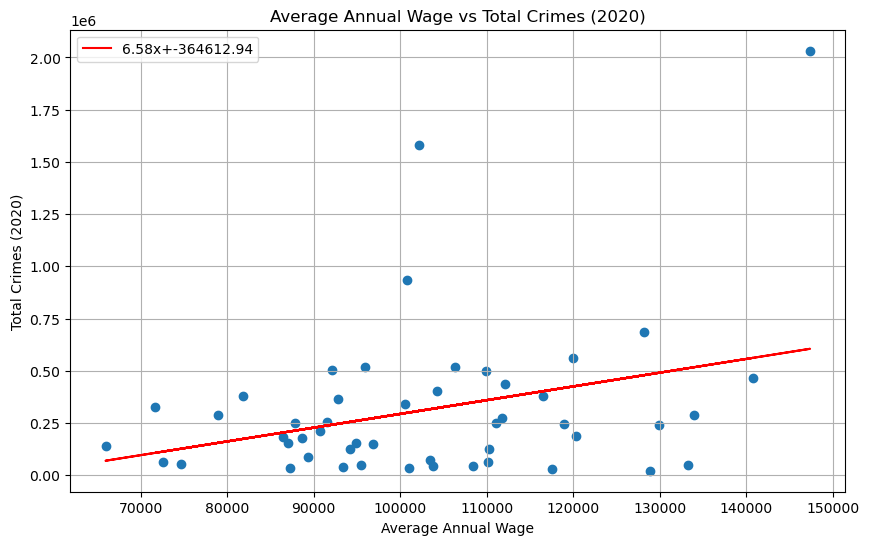

The correlation coefficient between Average Annual Wage and Total Crimes is 0.33


In [84]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(combined_data_clean['Average annual wage'], combined_data_clean['Total Crimes'])
plt.xlabel('Average Annual Wage')
plt.ylabel('Total Crimes (2020)')
plt.title('Average Annual Wage vs Total Crimes (2020)')
plt.grid(True)

x = combined_data_clean['Average annual wage']
y = combined_data_clean['Total Crimes']
m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b, color='red', label=f"{m:.2f}x+{b:.2f}")

plt.legend()
plt.show()

# Calculate the correlation coefficient between Average Annual Wage and Total Crimes
correlation_coefficient = round(st.pearsonr(combined_data_clean['Average annual wage'], combined_data_clean['Total Crimes'])[0], 2)
print(f"The correlation coefficient between Average Annual Wage and Total Crimes is {correlation_coefficient}")
